In [1]:
!pip install requests_html

In [3]:
from yahoo_fin.stock_info import get_data
from datetime import datetime, timedelta
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_predict
import warnings
import statsmodels.api as sm
import numpy as np
import pandas as pd
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.metrics import r2_score
from tqdm import tqdm 
warnings.filterwarnings("ignore")

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [4]:
def hiper_par(train):
    best_aic = np.inf
    best_bic = np.inf
    
    best_order = None
    best_mdl = None
    
    pq_rng = range(5)
    d_rng  = range(3)
    
    lags = []
    dif = []
    ave = []
    aic = []
    bic = []
    HQIC = []

    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    # print(i, d, j)
                    tmp_mdl = ARIMA(train, order=(i,d,j)).fit()
                    lags.append(i)
                    dif.append(d)
                    ave.append(j)
                    aic.append(tmp_mdl.aic)
                    bic.append(tmp_mdl.bic)
                    HQIC.append(tmp_mdl.hqic)
                except: continue
    
    results = pd.DataFrame({
        'lags': lags,
        'dif': dif,
        'ave': ave,
        'aic': aic,
        'bic': bic,
        'hqic': HQIC
    })
    
    return results

In [5]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

In [6]:
def arima_rolling(history, test, order):
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [7]:
stock = 'BTC-USD'
resolution = '1d'
end_date = datetime.now()
start_date = "2014-09-15"

In [8]:
CL_df = get_data(stock, start_date=start_date, end_date=end_date, interval=resolution, index_as_date=False)
CL_df = CL_df.dropna()
CL_df.head()

,date,open,high,low,close,adjclose,volume,ticker
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,BTC-USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,BTC-USD
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,BTC-USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,BTC-USD
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,BTC-USD


In [9]:
CL_df.describe()

,date,open,high,low,close,adjclose,volume
count,3657,3657.000000,3657.000000,3657.000000,3657.000000,3657.000000,3.657000e+03
mean,2019-09-19 00:00:23.625922816,17841.430996,18246.641689,17409.180158,17857.325002,17857.325002,1.763137e+10
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,2017-03-19 00:00:00,1163.780029,1186.579956,1125.810059,1166.719971,1166.719971,2.912560e+08
50%,2019-09-19 00:00:00,9162.514648,9309.754883,8975.525391,9170.540039,9170.540039,1.380769e+10
75%,2022-03-21 00:00:00,29225.759766,29600.626953,28803.585938,29230.111328,29230.111328,2.857563e+10
max,2024-09-21 00:00:00,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11
std,NaN,19648.884040,20087.929878,19168.462964,19658.960879,19658.960879,1.917633e+10


In [10]:
adf_result = adfuller(CL_df.close)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('La serie tiene una raíz unitaria y no es estacionaria (no se rechaza H0)')
else:
    print('La serie no tiene una raíz unitaria y es estacionaria (se rechaza H0)')

ADF Statistic: -0.879560
p-value: 0.794629
La serie tiene una raíz unitaria y no es estacionaria (no se rechaza H0)


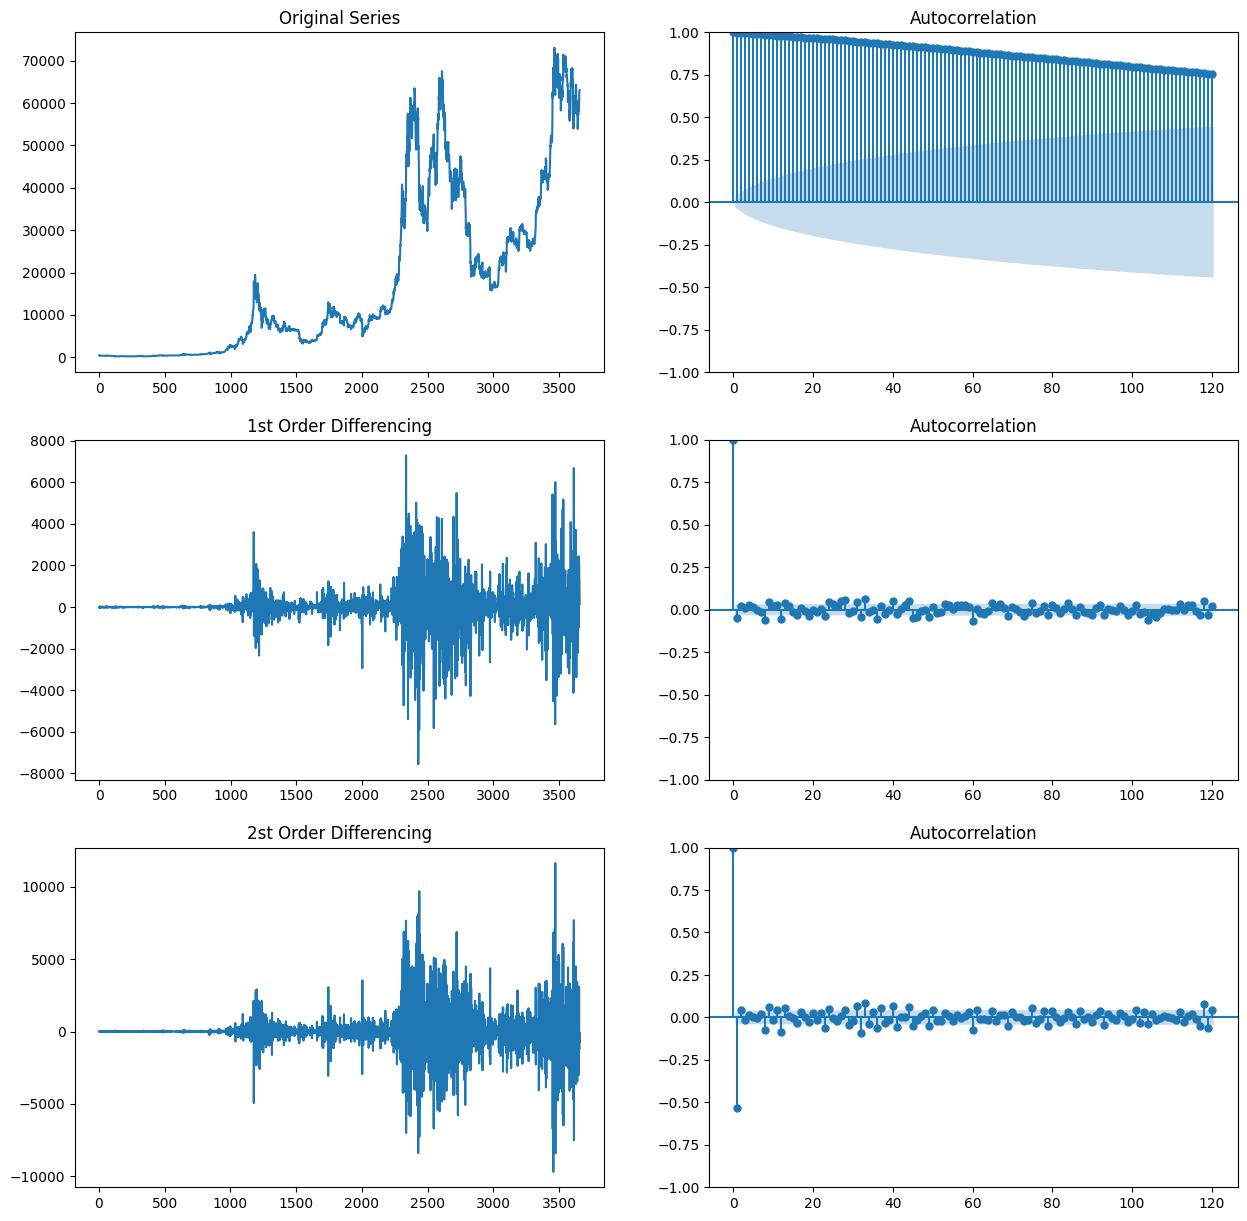

In [11]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(CL_df.close); axes[0, 0].set_title('Original Series')
plot_acf(CL_df.close, ax=axes[0, 1], lags = 120);

axes[1, 0].plot(CL_df.close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(CL_df.close.diff().dropna(), ax=axes[1, 1], lags = 120);

axes[2, 0].plot(CL_df.close.diff().diff()); axes[2, 0].set_title('2st Order Differencing')
plot_acf(CL_df.close.diff().diff().dropna(), ax=axes[2, 1], lags = 120);

# Entrenamiento del modelo

In [15]:
n_AAPL = len(CL_df.close); n_test = 28
train_size = n_AAPL - n_test

In [20]:
train = CL_df.close[:train_size]
dates_train = CL_df.date[:train_size]
test_4w = CL_df.close[train_size:train_size + 28]
dates_4w = CL_df.date[train_size:train_size + 28] 
print("train:", train.shape)
print("test_4w:", test_4w.shape)

train: (3629,)
test_4w: (28,)


In [22]:
results = hiper_par(train)

In [23]:
results.sort_values(by='aic', ascending=True).head()

,lags,dif,ave,aic,bic,hqic
69,4,1,4,59480.408041,59536.175972,59500.274632
59,3,2,4,59483.766849,59533.336138,59501.425503
67,4,1,2,59488.471074,59531.846132,59503.922867
52,3,1,2,59489.086598,59526.265219,59502.330992
38,2,1,3,59489.305990,59526.484610,59502.550384


In [24]:
results.sort_values(by='hqic', ascending=True).head()

,lags,dif,ave,aic,bic,hqic
26,1,2,1,59493.403084,59511.991567,59500.025079
69,4,1,4,59480.408041,59536.175972,59500.274632
12,0,2,2,59493.869610,59512.458093,59500.491605
59,3,2,4,59483.766849,59533.336138,59501.425503
52,3,1,2,59489.086598,59526.265219,59502.330992


## Modelo ARIMA(1,2,1)

In [30]:
best_order = (1,2,1)
model = ARIMA(train, order=best_order)
model_fit = model.fit()

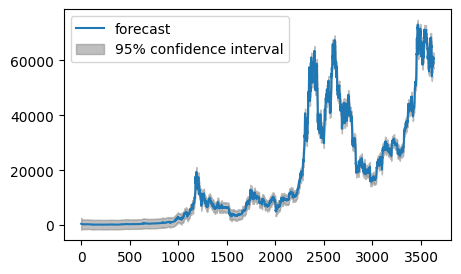

In [31]:
plt.rcParams.update({'figure.figsize': (5,3)})
fig, ax = plt.subplots();
plot_predict(model_fit, 2, ax=ax);
plt.show();

## Horizonte de 28 días

#### Rolling

In [135]:
test_4wl = test_4w.tolist()
yhat_4w  = arima_rolling(train.tolist(), test_4wl, order = (1,2,1))

predicted=61080.611496, expected=60381.914062
predicted=60441.564249, expected=64094.355469
predicted=63914.298510, expected=64178.992188
predicted=64193.038772, expected=64333.542969
predicted=64343.914238, expected=62880.660156
predicted=62976.136364, expected=59504.132812
predicted=59694.851390, expected=59027.625000
predicted=59068.729813, expected=59388.179688
predicted=59387.006240, expected=59119.476562
predicted=59150.107271, expected=58969.898438
predicted=58994.439337, expected=57325.488281
predicted=57425.127106, expected=59112.480469
predicted=59037.343600, expected=57431.023438
predicted=57535.945163, expected=57971.539062
predicted=57959.673974, expected=56160.488281
predicted=56272.917082, expected=53948.753906
predicted=54078.533280, expected=54139.687500
predicted=54145.363877, expected=54841.566406
predicted=54821.049546, expected=57019.535156
predicted=56924.523874, expected=57648.710938
predicted=57633.409411, expected=57343.171875
predicted=57375.088879, expected=5

In [233]:
forecast_accuracy(np.array(test_4wl), np.array(yhat_4w), "28 días")

,MAE,MSE,MAPE,RMSE,R2
28 días,1203.441449,2.382476e+06,0.020399,1543.527215,0.669047


Las métricas de precisión del modelo indican un rendimiento general relativamente bueno. El MAE y el RMSE sugieren que el modelo presenta errores promedio en el rango de aproximadamente 1203 a 1544 unidades, respectivamente. La MSE es alta, lo que indica la presencia de algunos errores significativos. Sin embargo, el MAPE de 2.04% muestra que, en promedio, el modelo está realizando predicciones con una desviación porcentual relativamente baja respecto a los valores reales. El R² de 0.6690 indica que el modelo explica aproximadamente el 66.9% de la variabilidad en los datos, lo que sugiere un ajuste razonable.

En conjunto, estas métricas sugieren que el modelo tiene un buen desempeño general, aunque hay margen para mejorar, especialmente en términos de errores extremos.

In [138]:
df_cor = pd.DataFrame({
    'Obs': test_4wl,
    'pred': yhat_4w
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.824849
pred,0.824849,1.000000


In [139]:
df_cor = pd.DataFrame({
    'Obs': test_4wl,
    'pred': yhat_4w
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.832245
pred,0.832245,1.000000


Ambas medidas de correlación (Spearman y Pearson) muestran valores altos, indicando que el modelo ARIMA(1,2,1) ha proporcionado predicciones que se correlacionan fuertemente tanto en términos lineales como monotónicos con los datos obsevados. Esto sugiere que el modelo es efectivo en capturar la dinámica y las tendencias en la serie temporal. Sin embargo, es importante considerar otros aspectos del ajuste del modelo, a saber: la normalidad, la estacionariedad, la falta de autcorrelación, o la heterocedasticidad de los residuos.

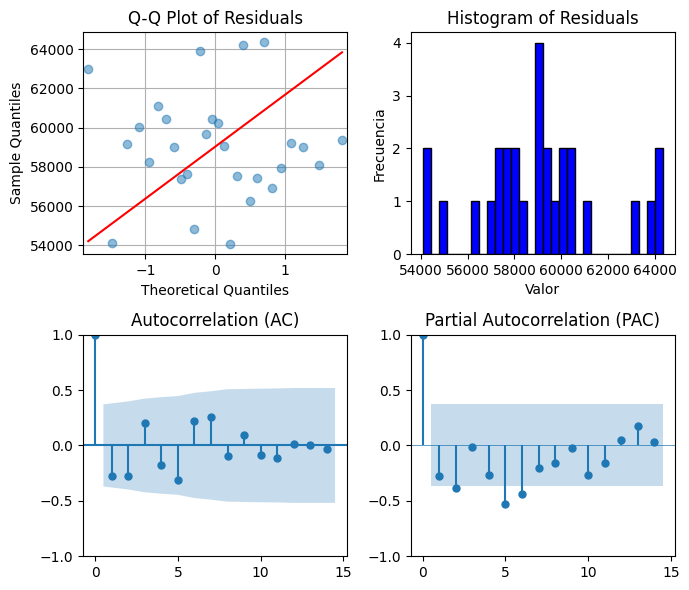

In [159]:
residuos = pd.DataFrame(list(set(yhat_4w) - set(test_4wl)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

El análisis visual de los residuos sugiere que, aunque los errores del modelo se aproximan a una distribución normal y parecen ser estacionarios, los rezagos en el gráfico de autocorrelación parcial sugieren la presencia de patrones adicionales que el modelo ARIMA(1,2,1) no ha capturado completamente. Para investigar estas hipótesis, se llevarán a cabo múltiples pruebas analíticas adicionales.

In [145]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.955, p=0.260
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [146]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -5.156353
p-value: 0.000011
Los residuos son estacionarios (se rechaza H0)


Como se observó en el histograma, la prueba de Shapiro-Wilk confirma que los errores del modelo ARIMA(1,2,1) se aproximan a una distribución gaussiana. Asimismo, la prueba de Dickey-Fuller indica que los residuos son estacionarios.

In [37]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 16.405455
p-value: 0.088599
Los residuos no están correlacionados (no se rechaza H0)


Aunque la prueba de Ljung-Box sugiere que los residuos no presentan autocorrelación significativa a los lags considerados, el valor extremadamente bajo de Durbin-Watson señala una fuerte autocorrelación positiva. Esto sugiere que el modelo ARIMA(1,2,1) podría no haber abordado completamente la estructura temporal subyacente de los datos.

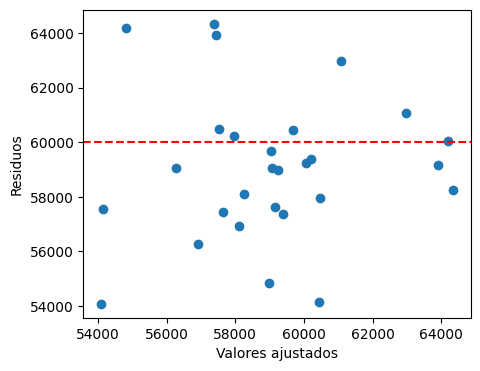

In [160]:
plt.scatter(yhat_4w, residuos)
plt.axhline(y=60000, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

Finalmente, el gráfico comparativo de los valores ajustados con los residuos no revela patrones evidentes de heterocedasticidad. Esto sugiere que, en términos generales, los residuos tienen una variabilidad relativamente constante en relación con los valores ajustados, lo cual es un buen indicador de que no hay problemas significativos de heterocedasticidad en el modelo.

Sin embargo, es importante tener en cuenta que, aunque no se observan patrones claros en los residuos, las pruebas de autocorrelación sugieren que el modelo ARIMA(1,2,1) podría no capturar completamente todas las dependencias temporales en los datos. Esto indica que podría ser beneficioso revisar el modelo y considerar ajustes adicionales para mejorar su capacidad de capturar la estructura temporal y abordar cualquier posible autocorrelación residual.

### Sin rolling

In [170]:
pronostico = model_fit.forecast(steps=len(dates_4w))

In [195]:
forecast_accuracy(np.array(test_4w), np.array(pronostico), "28 días")

,MAE,MSE,MAPE,RMSE,R2
28 días,2662.228829,1.019732e+07,0.043882,3193.32416,-0.416525


Las métricas indican un rendimiento significativamente inferior en comparación con el modelo utilizando "rolling". El MAE y el RMSE muestran errores más altos, con desviaciones promedio de aproximadamente 2662 y 3193 unidades, respectivamente, lo que sugiere que el modelo tiene dificultades para hacer predicciones precisas. El MSE elevado indica la presencia de errores muy grandes, y el MAPE de 4.39% refleja que el modelo se desvía, en promedio, un 4.39% de los valores reales, el doble que en el modelo con rolling.

El R² negativo (-0.4165) es especialmente preocupante, ya que indica que el modelo es menos útil que una simple media de los datos. Esto significa que el modelo sin rolling no captura adecuadamente la variabilidad de los datos y podría estar haciendo predicciones ineficaces. En resumen, el modelo sin rolling muestra un desempeño considerablemente peor, con errores más grandes y una capacidad predictiva limitada.

In [172]:
df_cor = pd.DataFrame({
    'Obs': test_4w,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,-0.263736
pred,-0.263736,1.000000


In [173]:
df_cor = pd.DataFrame({
    'Obs': test_4w,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.378099
pred,-0.378099,1.000000


Ambas medidas de correlación (Spearman y Pearson) muestran valores negativos moderados, lo que indica que el modelo ARIMA(1,2,1) ha producido predicciones que se correlacionan de manera inversa con los datos observados, tanto en términos lineales como monotónicos. Esto sugiere que el modelo no ha capturado adecuadamente la dinámica y las tendencias en la serie temporal. Es crucial examinar otros aspectos del ajuste del modelo, como la normalidad, la estacionariedad, la falta de autocorrelación o la heterocedasticidad de los residuos, para evaluar completamente su rendimiento.

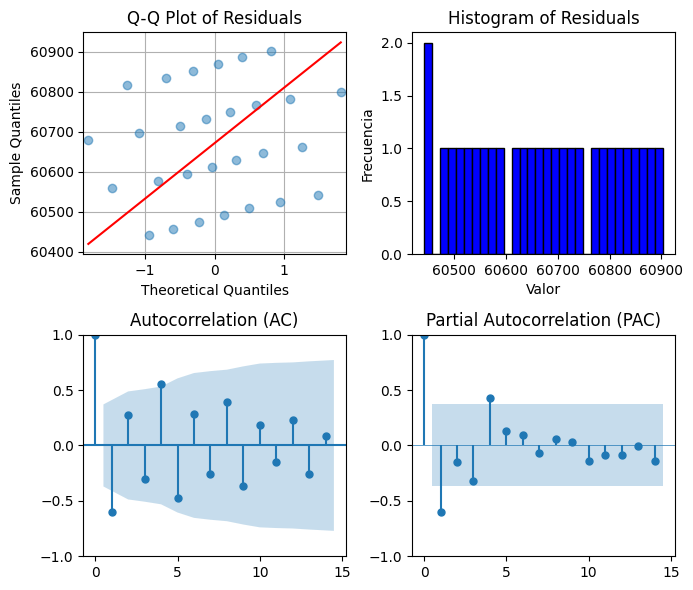

In [174]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_4wl)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

El análisis visual de los residuos sugiere que, aunque los errores del modelo parecen ser estacionarios, los rezagos en el gráfico de autocorrelación parcial sugieren la presencia de patrones adicionales que el modelo ARIMA(1,2,1) no ha capturado completamente. No se encuentran patrones en el grafico cuantil-cuantil o el histograma que sugieren que los errores se aproximan a una distribucion guassina. Para investigar estas hipótesis, se llevarán a cabo múltiples pruebas analíticas adicionales.

In [179]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.957, p=0.298
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [180]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -4.585556
p-value: 0.000137
Los residuos son estacionarios (se rechaza H0)


In [181]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 55.241742
p-value: 0.000000
Los residuos están correlacionados (se rechaza H0)


Los resultados indican que el modelo presenta ciertos aciertos, pero también limitaciones. Los errores se aproximan a una distribución normal y son estacionarios, lo cual es positivo y sugiere que el modelo captura algunos aspectos importantes de los datos. Sin embargo, la autocorrelación detectada en los residuos (a través de la prueba de Ljung-Box y el estadístico de Durbin-Watson) sugiere que el modelo no ha captado completamente la estructura temporal de los datos. Esto indica que, aunque el modelo tiene buenos fundamentos, aún puede mejorarse para corregir los patrones residuales no explicados.

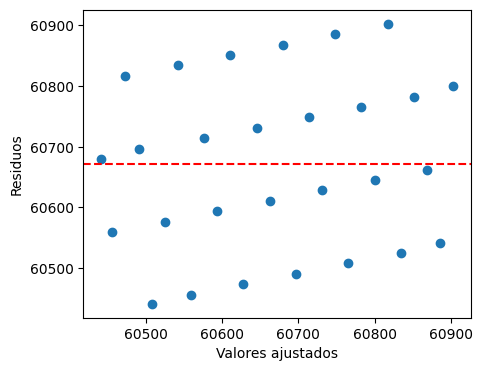

In [178]:
plt.scatter(pronostico, residuos)
plt.axhline(y=60671.056926, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

La gráfica de valores ajustados versus residuos no presenta patrones que indiquen heterocedasticidad, lo que sugiere que la varianza de los errores es constante. Esto es un aspecto positivo, ya que indica que el modelo ha capturado adecuadamente la dispersión de los datos y que los residuos no varían de manera sistemática con respecto a las predicciones. Sin embargo, dado que las pruebas anteriores señalaron autocorrelación en los errores, aunque no hay heterocedasticidad, el modelo aún podría beneficiarse de ajustes adicionales para mejorar su capacidad de capturar la estructura temporal.

### Resultado general: Horizonte de 28 días

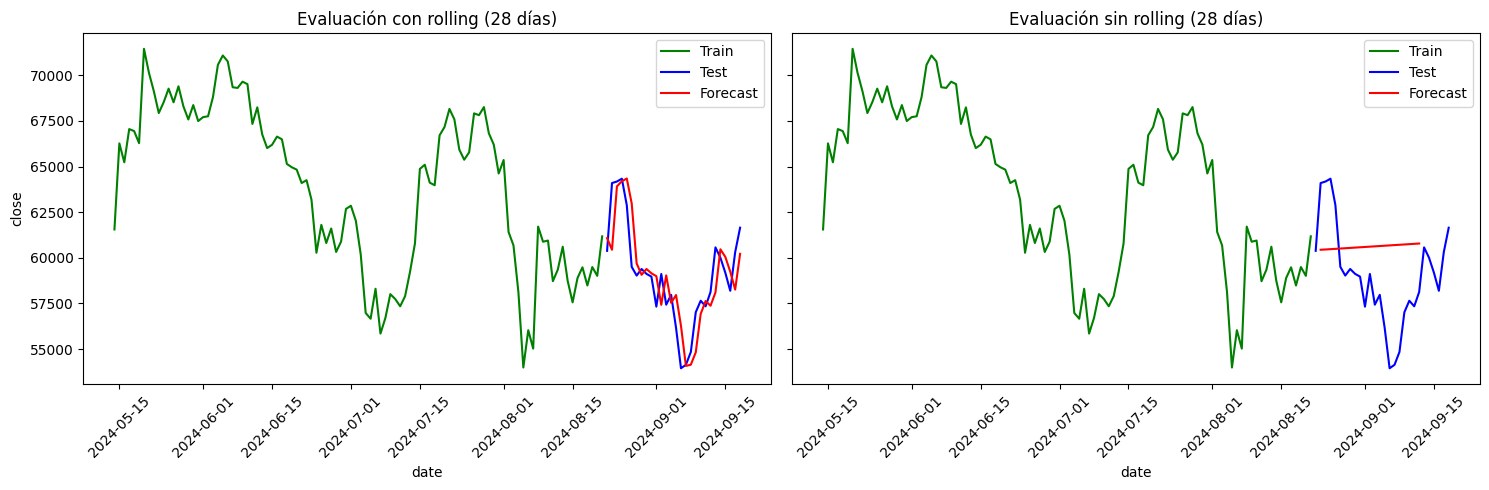

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_4w, y=test_4wl, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_4w, y=yhat_4w, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (28 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_4w, y=test_4w, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_4w, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (28 días)')

plt.tight_layout()
plt.show()

En resumen, el modelo evaluado con técnicas de rolling muestra un rendimiento superior en términos de ajuste, con errores menores y un R² positivo, lo que indica una buena capacidad para capturar la variabilidad de los datos. Además, cumple con los supuestos de normalidad, estacionariedad y ausencia de heterocedasticidad. No obstante, persiste un problema con la autocorrelación de los errores, lo que sugiere que aún hay patrones temporales no capturados por el modelo y que necesitan ser abordados.

En contraste, el modelo evaluado sin rolling presenta un ajuste deficiente, con errores más altos y un R² negativo. Esto indica que el modelo no es efectivo en capturar las tendencias de los datos y requiere mejoras significativas. En general, mientras que el uso de técnicas de rolling proporciona una evaluación más flexible y ajustada a las características temporales de los datos, ambos enfoques destacan la necesidad de ajustar el modelo para mejorar la precisión y la capacidad de capturar la estructura temporal de los datos.

## Horizonte de 21 días

In [183]:
test_21d = CL_df.close[train_size:train_size + 21] 
dates_21d = CL_df.date[train_size:train_size + 21]

### Rolling

In [184]:
test_21d = test_21d.tolist()
yhat_21d  = arima_rolling(train.tolist(), test_21d, order = (1,2,1))

predicted=61080.611496, expected=60381.914062
predicted=60441.564249, expected=64094.355469
predicted=63914.298510, expected=64178.992188
predicted=64193.038772, expected=64333.542969
predicted=64343.914238, expected=62880.660156
predicted=62976.136364, expected=59504.132812
predicted=59694.851390, expected=59027.625000
predicted=59068.729813, expected=59388.179688
predicted=59387.006240, expected=59119.476562
predicted=59150.107271, expected=58969.898438
predicted=58994.439337, expected=57325.488281
predicted=57425.127106, expected=59112.480469
predicted=59037.343600, expected=57431.023438
predicted=57535.945163, expected=57971.539062
predicted=57959.673974, expected=56160.488281
predicted=56272.917082, expected=53948.753906
predicted=54078.533280, expected=54139.687500
predicted=54145.363877, expected=54841.566406
predicted=54821.049546, expected=57019.535156
predicted=56924.523874, expected=57648.710938
predicted=57633.409411, expected=57343.171875


In [185]:
forecast_accuracy(np.array(test_21d), np.array(yhat_21d), "21 días")

,MAE,MSE,MAPE,RMSE,R2
21 days,1172.294916,2.463805e+06,0.01985,1569.651226,0.723467


Para el horizonte de 21 días, el modelo demuestra un buen rendimiento, con un MAE y un RMSE bajos, indicando una alta precisión en las predicciones. El MAPE es de 1.985%, lo que muestra que el error porcentual medio es pequeño, sugiriendo que las predicciones están cerca de los valores reales. Además, un R² de 0.7235 sugiere que el modelo explica aproximadamente el 72.35% de la variabilidad en los datos, reflejando un ajuste sólido y una capacidad efectiva para capturar las tendencias de los datos.

In [186]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': yhat_21d
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.879221
pred,0.879221,1.000000


In [187]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': yhat_21d
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.864048
pred,0.864048,1.000000


La alta correlación de Spearman de 0.88 y la correlación de Pearson de 0.86 entre los datos de prueba y los datos predichos indican una fuerte relación entre las predicciones y los valores reales. Estos resultados sugieren que el modelo es muy efectivo en capturar tanto las relaciones monotónicas (Spearman) como lineales (Pearson) en los datos, lo que refuerza la precisión y fiabilidad del modelo.

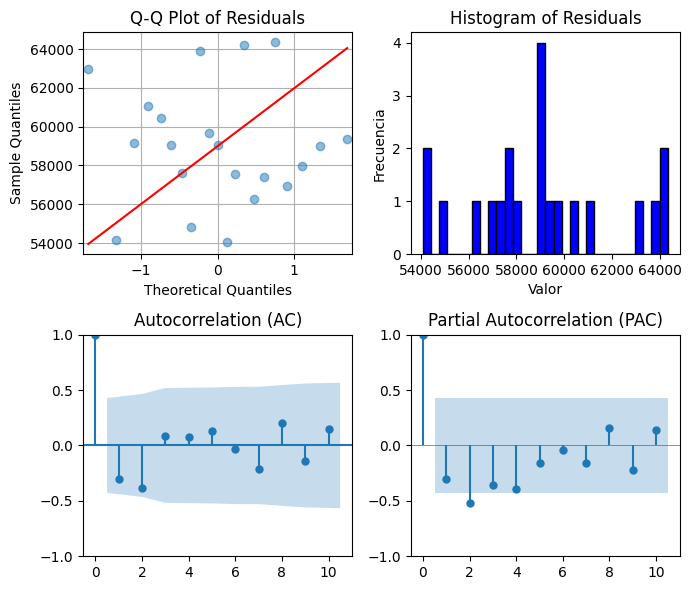

In [209]:
residuos = pd.DataFrame(list(set(yhat_21d) - set(test_21d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

El análisis visual de los residuos sugiere que, aunque los errores del modelo se aproximan a una distribución normal y parecen ser estacionarios, los rezagos en el gráfico de autocorrelación parcial sugieren la presencia de patrones adicionales que el modelo ARIMA(1,2,1) no ha capturado completamente. Para investigar estas hipótesis, se llevarán a cabo múltiples pruebas analíticas adicionales.

In [189]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.947, p=0.295
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [190]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -5.883485
p-value: 0.000000
Los residuos son estacionarios (se rechaza H0)


In [191]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 11.683161
p-value: 0.306821
Los residuos no están correlacionados (no se rechaza H0)


Las pruebas realizadas sugieren que el modelo cumple en gran medida con los supuestos necesarios para un ajuste adecuado. La prueba de Shapiro indica que los residuos se aproximan a una distribución normal, y la prueba de Dickey-Fuller confirma que son estacionarios, lo cual es positivo. Además, la prueba de Ljung-Box muestra que los residuos no están correlacionados, indicando que el modelo ha capturado la estructura temporal en gran medida. Sin embargo, el bajo valor del estadístico de Durbin-Watson sugiere una alta autocorrelación positiva en los residuos, lo que implica que el modelo podría no haber capturado completamente todos los patrones temporales, sugiriendo que se podrían realizar ajustes adicionales para mejorar la modelización.

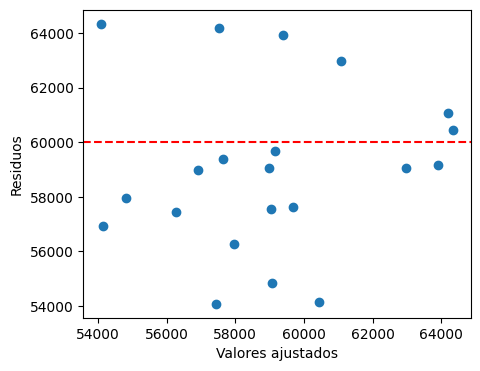

In [194]:
plt.scatter(yhat_21d, residuos)
plt.axhline(y=60000, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

La gráfica de residuos frente a datos ajustados muestra que no hay patrones evidentes, lo cual sugiere que no hay heterocedasticidad en los residuos. Esto es consistente con la interpretación previa que indicaba que el modelo cumple con los supuestos de normalidad y estacionariedad, y que los residuos no están correlacionados. La ausencia de heterocedasticidad en esta gráfica refuerza la conclusión de que el modelo ha capturado bien la variabilidad en los datos y que los errores son consistentes a lo largo de las predicciones, aunque la alta autocorrelación positiva identificada por la prueba de Durbin-Watson sugiere que aún podrían existir patrones temporales no completamente capturados.

### Sin rolling

In [213]:
pronostico = model_fit.forecast(steps=len(dates_21d))

In [214]:
forecast_accuracy(np.array(test_21d), np.array(pronostico), "21 días")

,MAE,MSE,MAPE,RMSE,R2
21 días,3101.314158,1.270483e+07,0.051142,3564.384169,-0.425968


Las métricas de ajuste del modelo sin rolling para un horizonte de 21 días indican un desempeño deficiente. El MAE de 3101.31 y el RMSE de 3564.38 muestran que los errores promedio y las desviaciones de las predicciones respecto a los valores reales son bastante altos. El MAPE del 5.11% sugiere que el modelo comete errores importantes en relación con los valores reales. Además, el R² negativo (-0.43) indica que el modelo es peor que un modelo de referencia simple (como el promedio), lo que significa que no captura adecuadamente la variabilidad de los datos. Estos resultados sugieren que el modelo sin rolling no es efectivo para este horizonte de predicción.

In [215]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,-0.862338
pred,-0.862338,1.000000


In [216]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.820956
pred,-0.820956,1.000000


Los coeficientes de correlación de Spearman (-0.87) y Pearson (-0.82) entre los datos de prueba y los datos predichos indican una fuerte correlación negativa tanto en términos monotónicos como lineales. Esto sugiere que, en lugar de capturar correctamente las tendencias de los datos, el modelo está produciendo predicciones que se mueven en la dirección opuesta a los valores reales. Este comportamiento negativo refuerza la conclusión de que el modelo está fallando en representar adecuadamente la estructura de los datos y puede estar sobreajustado o mal especificado para este conjunto de prueba.

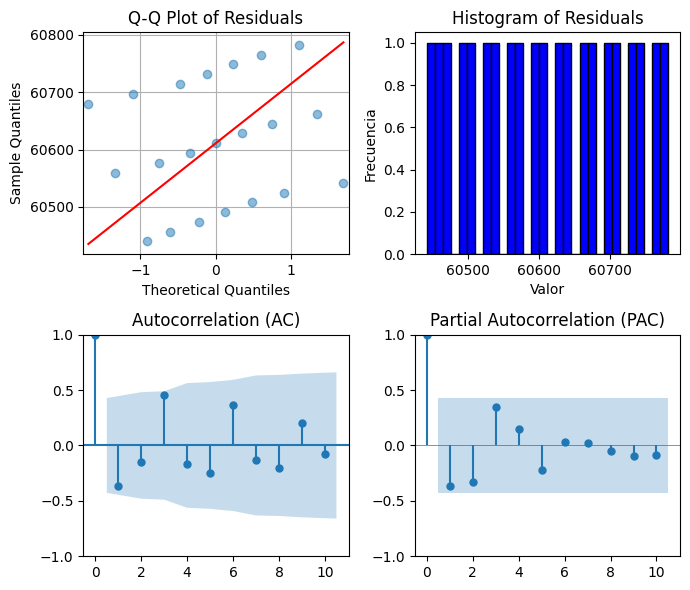

In [201]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_21d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

El análisis visual de los residuos del modelo indica que los errores son estacionarios y no presentan signos evidentes de autocorrelación. Además, tanto el gráfico cuantil-cuantil como el histograma no sugieren que los errores se aproximen a una distribución gaussiana. Sin embargo, se observan posibles patrones adicionales que el modelo ARIMA(1,2,1) no ha capturado por completo. Para explorar más a fondo estas hipótesis, se realizarán pruebas analíticas adicionales.

In [217]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.947, p=0.295
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [218]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -5.883485
p-value: 0.000000
Los residuos son estacionarios (se rechaza H0)


In [219]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 11.683161
p-value: 0.306821
Los residuos no están correlacionados (no se rechaza H0)


En general, los resultados indican que el modelo ARIMA(1,2,1) cumple con varios supuestos importantes: los residuos se aproximan a una distribución normal, son estacionarios y no muestran evidencia de correlación según la prueba de Ljung-Box. Sin embargo, el valor extremadamente bajo de la prueba de Durbin-Watson sugiere que podría haber una fuerte autocorrelación positiva en los residuos, lo que contradice otros resultados y requiere una mayor investigación. A pesar de esto, el modelo parece ajustarse razonablemente bien, aunque podría beneficiarse de ajustes adicionales para mejorar su rendimiento.

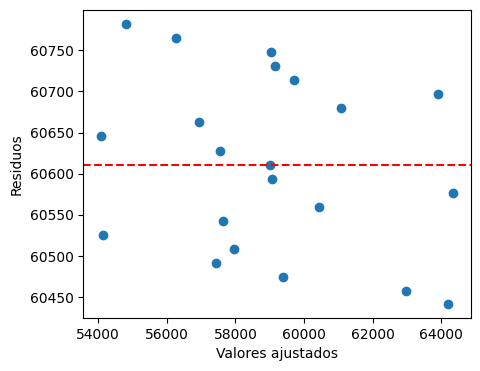

In [208]:
plt.scatter(pronostico, residuos)
plt.axhline(y=60611.052394, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

La falta de heterocedasticidad observada en la gráfica de valores ajustados vs. residuos no mejora el panorama general del modelo sin rolling. Aunque los residuos parecen cumplir con los supuestos de estacionariedad, normalidad y no autocorrelación, los resultados negativos del desempeño del modelo, como el R² negativo (-0.43) y las correlaciones negativas entre los datos predichos y los observados, refuerzan la conclusión de que el modelo está mal especificado o sobreajustado. A pesar de que no se observa heterocedasticidad, el modelo claramente falla en capturar la estructura subyacente de los datos y no es adecuado para predicciones en este horizonte temporal.

### Resultado general: Horizonte de 21 días

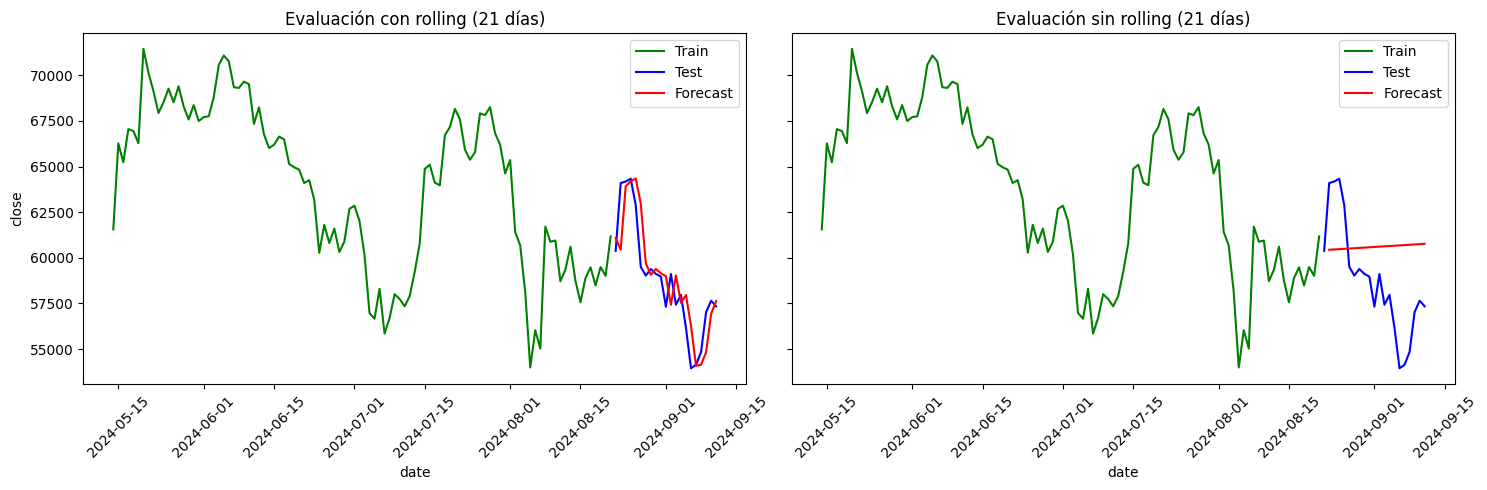

In [212]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_21d, y=test_21d, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_21d, y=yhat_21d, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (21 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_21d, y=test_21d, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_21d, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (21 días)')

plt.tight_layout()
plt.show()

En resumen, el modelo evaluado con rolling muestra un rendimiento notablemente mejor que el modelo sin rolling. Con rolling, las métricas de ajuste como MAE, RMSE y R² son más favorables, lo que indica que las predicciones son más precisas y reflejan mejor la estructura temporal de los datos. Por otro lado, el modelo sin rolling tiene un ajuste deficiente, con errores elevados y un R² negativo, sugiriendo que es inadecuado para el horizonte temporal analizado. Aunque en ambos casos los residuos cumplen con los supuestos de estacionariedad y normalidad y no muestran heterocedasticidad, el valor de Durbin-Watson cercano a cero en ambos modelos indica una posible autocorrelación positiva en los residuos. Esto sugiere que, a pesar del mejor desempeño del modelo con rolling, ambos modelos podrían beneficiarse de ajustes adicionales para abordar la autocorrelación y mejorar la precisión general.

## Horizonte de 14 días

In [260]:
test_14d = CL_df.close[train_size:train_size + 14] 
dates_14d = CL_df.date[train_size:train_size + 14]

### Rolling

In [261]:
test_14d = test_14d.tolist()
yhat_14d  = arima_rolling(train.tolist(), test_14d, order = (1,2,1))

predicted=61080.611496, expected=60381.914062
predicted=60441.564249, expected=64094.355469
predicted=63914.298510, expected=64178.992188
predicted=64193.038772, expected=64333.542969
predicted=64343.914238, expected=62880.660156
predicted=62976.136364, expected=59504.132812
predicted=59694.851390, expected=59027.625000
predicted=59068.729813, expected=59388.179688
predicted=59387.006240, expected=59119.476562
predicted=59150.107271, expected=58969.898438
predicted=58994.439337, expected=57325.488281
predicted=57425.127106, expected=59112.480469
predicted=59037.343600, expected=57431.023438
predicted=57535.945163, expected=57971.539062


In [288]:
forecast_accuracy(np.array(test_14d), np.array(yhat_14d), "14 días")

,MAE,MSE,MAPE,RMSE,R2
14 días,1180.326958,2.655046e+06,0.019476,1629.431086,0.549558


El modelo ARIMA(1,2,1) evaluado con un horizonte de 14 días y utilizando una técnica de evaluación rolling muestra un rendimiento aceptable. El MAPE del 1.95% indica que los errores son relativamente bajos en relación con los valores reales, lo que sugiere una buena precisión en términos porcentuales. El MAE de 1180.33 y el RMSE de 1629.43 reflejan errores promedio moderados y la variabilidad en las predicciones, respectivamente. Además, el R² de 0.55 señala que el modelo logra capturar más de la mitad de la variabilidad de los datos. Estos resultados sugieren que el modelo tiene un buen ajuste, aunque puede haber margen para mejorar su precisión.

In [264]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': yhat_14d
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.824176
pred,0.824176,1.000000


In [265]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': yhat_14d
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.770467
pred,0.770467,1.000000



Las correlaciones de Spearman (0.82) y Pearson (0.77) muestran que el modelo ARIMA(1,2,1) con rolling captura de manera sólida tanto las relaciones monotónicas como lineales entre los datos predichos y los datos de prueba. Esto sugiere que el modelo refleja adecuadamente las tendencias generales y los patrones subyacentes de la serie temporal. Aunque la correlación de Pearson es ligeramente menor, sigue indicando un ajuste satisfactorio en términos lineales, lo que respalda la utilidad del modelo para este horizonte de predicción.

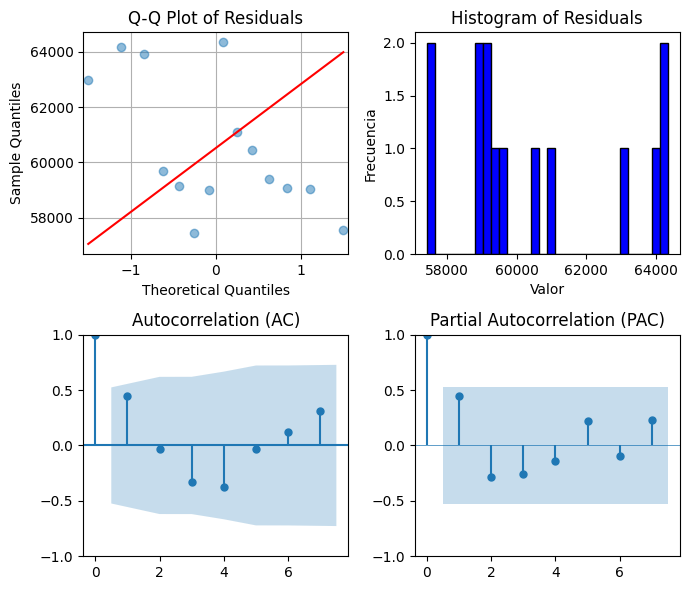

In [266]:
residuos = pd.DataFrame(list(set(yhat_14d) - set(test_14d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos indica que los errores del modelo ARIMA(1,2,1) son estacionarios y no muestran autocorrelación significativa. Sin embargo, tanto el gráfico cuantil-cuantil como el histograma no respaldan que los errores sigan una distribución normal de manera clara. Para evaluar estas observaciones de forma más rigurosa, se llevarán a cabo diversas pruebas analíticas adicionales.

In [267]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.878, p=0.055
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [268]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -1.809534
p-value: 0.375739
Los residuos no son estacionarios (no se rechaza H0)


In [269]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 14.200534
p-value: 0.164040
Los residuos no están correlacionados (no se rechaza H0)


Los resultados sugieren que el modelo ARIMA(1,2,1) presenta algunas deficiencias en la captura de la estructura de los datos. Aunque la inspección visual de los residuos no muestra patrones evidentes de autocorrelación o heterocedasticidad, las pruebas estadísticas arrojan información más matizada. La prueba de Shapiro-Wilk (p = 0.055) sugiere que los errores se aproximan a una distribución normal, aunque no de manera contundente. Por otro lado, la prueba de Dickey-Fuller revela que los residuos no son estacionarios (p = 0.3757), lo que indica variaciones en su comportamiento a lo largo del tiempo. A pesar de la falta de autocorrelación según la prueba de Ljung-Box, el estadístico extremadamente bajo de Durbin-Watson (0.0013) indica que persisten problemas de correlación positiva en los errores. En conjunto, estos resultados sugieren que, aunque algunos supuestos se cumplen parcialmente, el modelo aún presenta limitaciones importantes.

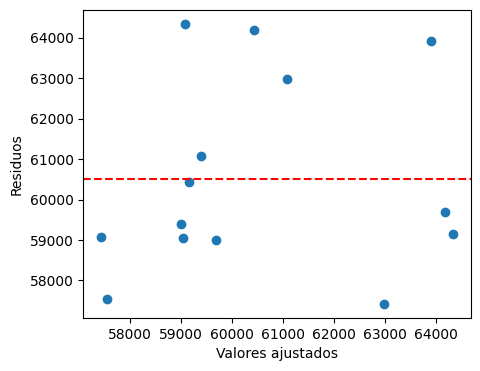

In [273]:
plt.scatter(yhat_14d, residuos)
plt.axhline(y=60517.365254, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

La gráfica de residuos frente a los valores ajustados no revela tendencias visibles que sugieran la presencia de heterocedasticidad, es decir, la varianza de los errores parece ser constante a lo largo de las predicciones. Esto es un buen indicio, ya que sugiere que el modelo ARIMA(1,2,1) no presenta problemas evidentes de variabilidad en los errores a diferentes niveles de predicción. Sin embargo, aunque la ausencia de heterocedasticidad es favorable, es importante tener en cuenta que otros supuestos, como la estacionariedad y la falta de correlación en los errores, no se cumplen plenamente según los resultados de las pruebas estadísticas, lo que indica que el modelo aún tiene áreas por mejorar en su ajuste.

### Sin Rolling

In [274]:
pronostico = model_fit.forecast(steps=len(dates_14d))

In [275]:
forecast_accuracy(np.array(test_14d), np.array(pronostico), "14 días")

,MAE,MSE,MAPE,RMSE,R2
14 días,2222.315467,6.249612e+06,0.036701,2499.922334,-0.060277


Los índices de ajuste del modelo sin rolling para un horizonte de 14 días indican un rendimiento pobre en comparación con el modelo evaluado con rolling. El MAE de 2222.32 y el RMSE de 2499.92 revelan errores sustanciales entre las predicciones y los valores reales. El MAPE del 3.67% muestra un nivel significativo de error relativo, lo que indica que las predicciones están lejos de ser precisas en relación con los datos observados. El R² negativo (-0.06) es particularmente preocupante, ya que sugiere que el modelo no logra capturar la variabilidad de los datos mejor que un modelo de referencia simple, como el promedio. En conjunto, estos resultados indican que el modelo sin rolling no es efectivo para predecir en un horizonte de 14 días.

In [236]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,-0.863736
pred,-0.863736,1.000000


In [276]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.804252
pred,-0.804252,1.000000


Los coeficientes de correlación de Spearman (-0.86) y Pearson (-0.80) indican una relación negativa significativa entre los datos predichos y los datos de prueba. Esto sugiere que, a medida que los valores reales aumentan, las predicciones del modelo tienden a disminuir y viceversa. Este comportamiento refleja que el modelo está capturando de manera incorrecta la estructura de los datos y podría estar mal especificado o sobreajustado, lo que explica su desempeño deficiente.

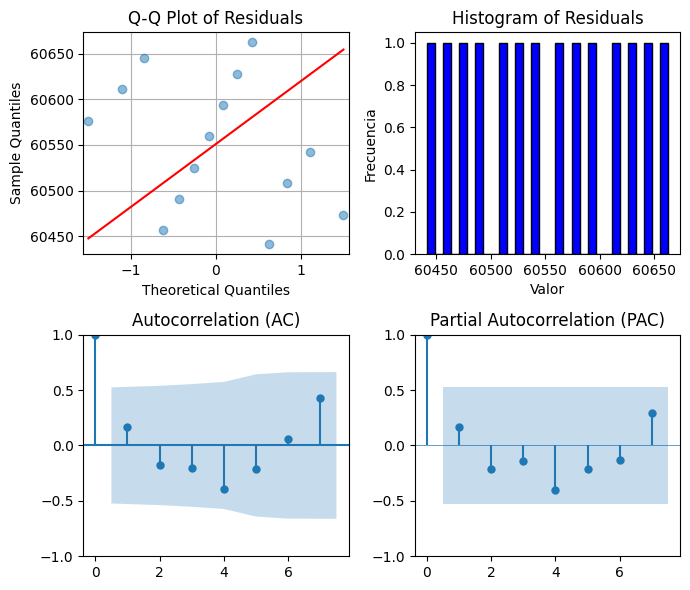

In [277]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_14d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

Tal como en el caso anterior, la inspección visual de los residuos indica que los errores del modelo ARIMA(1,2,1) son estacionarios y no muestran autocorrelación significativa. Sin embargo, tanto el gráfico cuantil-cuantil como el histograma no respaldan que los errores sigan una distribución normal de manera clara. Para evaluar estas observaciones de forma más rigurosa, se llevarán a cabo diversas pruebas analíticas adicionales.

In [279]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.963, p=0.769
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [280]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -315.398717
p-value: 0.000000
Los residuos son estacionarios (se rechaza H0)


In [281]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 12.711525
p-value: 0.240251
Los residuos no están correlacionados (no se rechaza H0)


En el modelo sin rolling, aunque los residuos parecen ajustarse a una distribución normal y no presentan autocorrelación significativa según la prueba de Ljung-Box, la prueba de Dickey-Fuller indica que los errores no son estacionarios. Además, el bajo valor del estadístico de Durbin-Watson sugiere una fuerte autocorrelación en los residuos. Estos resultados indican que, a pesar de cumplir con algunos supuestos como la normalidad y la falta de autocorrelación, el modelo no es capaz de capturar adecuadamente la estructura temporal de los datos debido a la falta de estacionariedad en los errores. Esto limita la efectividad del modelo para hacer predicciones precisas y sugiere que se podrían necesitar ajustes adicionales para mejorar su rendimiento.

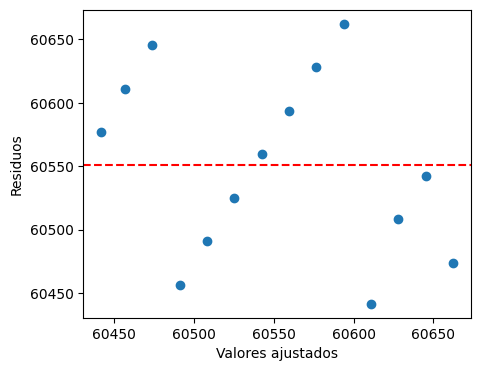

In [283]:
plt.scatter(pronostico, residuos)
plt.axhline(y=60551.071817, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

Al graficar los datos ajustados frente a los residuos, no se observan patrones que sugieran heterocedasticidad. Esto significa que, aunque los residuos no muestran una variabilidad creciente o decreciente en relación con los valores ajustados, la falta de estacionariedad identificada en los errores indica que el modelo aún presenta deficiencias en capturar la estructura temporal adecuada de los datos. En conjunto con los resultados de la prueba de Dickey-Fuller y el bajo valor del estadístico de Durbin-Watson, estos hallazgos sugieren que, a pesar de la ausencia de heterocedasticidad, el modelo sin rolling no es completamente efectivo debido a la falta de estacionariedad y la posible autocorrelación en los residuos.

### Resultado general: Horizonte de 14 días

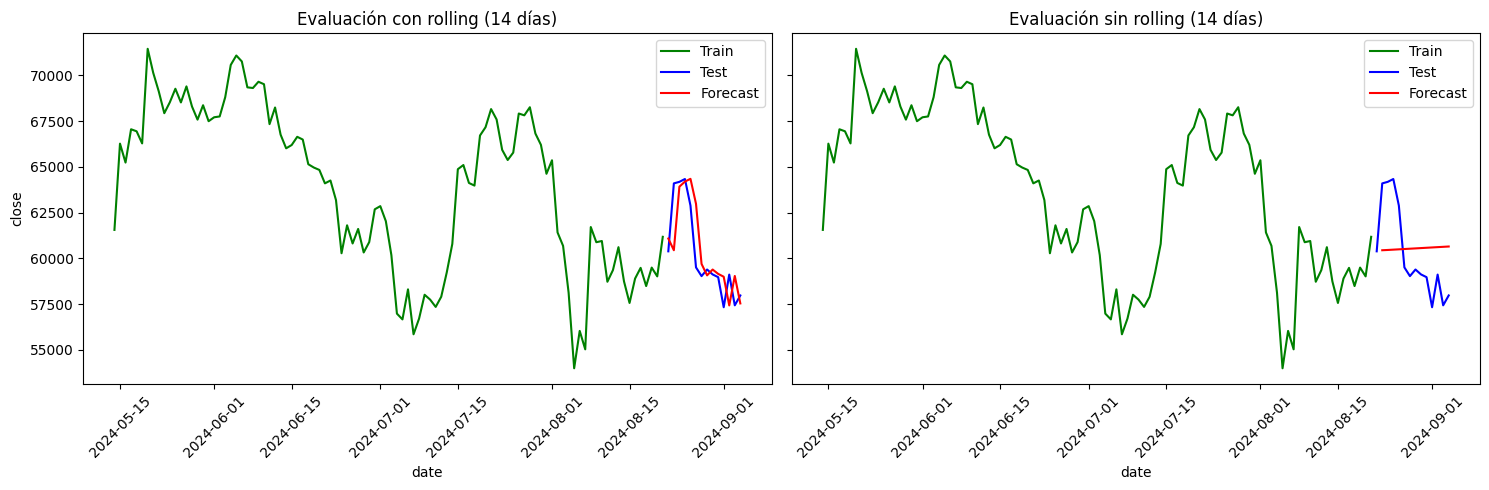

In [244]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_14d, y=test_14d, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_14d, y=yhat_14d, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (14 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_14d, y=test_14d, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_14d, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (14 días)')

plt.tight_layout()
plt.show()

Al evaluar el mismo modelo ARIMA(1,2,1) con y sin la técnica de rolling para un horizonte de 14 días, se observa que el modelo con rolling ofrece un mejor ajuste, con un R² de 0.54, y no presenta problemas evidentes de heterocedasticidad. Sin embargo, ambos enfoques enfrentan desafíos en términos de estacionariedad y correlación de errores. El modelo sin rolling tiene un R² negativo y, aunque no muestra heterocedasticidad, la falta de estacionariedad y posibles problemas de autocorrelación indican que el modelo tiene deficiencias significativas en capturar la estructura temporal adecuada de los datos.

## Horizonte de 7 días

In [286]:
test_7d = CL_df.close[train_size:train_size + 7] 
dates_7d = CL_df.date[train_size:train_size + 7]

### Rolling

In [289]:
test_7d = test_7d.tolist()
yhat_7d  = arima_rolling(train.tolist(), test_7d, order = (1,2,1))

predicted=61080.611496, expected=60381.914062
predicted=60441.564249, expected=64094.355469
predicted=63914.298510, expected=64178.992188
predicted=64193.038772, expected=64333.542969
predicted=64343.914238, expected=62880.660156
predicted=62976.136364, expected=59504.132812
predicted=59694.851390, expected=59027.625000


In [290]:
forecast_accuracy(np.array(test_7d), np.array(yhat_7d), "7 días")

,MAE,MSE,MAPE,RMSE,R2
7 días,1479.881507,4.080283e+06,0.023894,2019.97094,0.134876


Para el modelo ARIMA(1,2,1) evaluado en una ventana de 7 días, las métricas de ajuste muestran un rendimiento moderado. Aunque el MAE y el RMSE sugieren que el modelo tiene errores relativamente grandes en términos absolutos y cuadrados, el MAPE indica que el error porcentual promedio es bajo, lo que es favorable. El R² de 0.13 indica que el modelo explica solo una pequeña fracción de la variabilidad en los datos, sugiriendo que el modelo tiene un ajuste limitado para esta ventana temporal. En general, mientras que el modelo muestra un error porcentual aceptable, la capacidad de explicación de la variabilidad de los datos es baja.

In [291]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': yhat_7d
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.571429
pred,0.571429,1.000000


In [292]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': yhat_7d
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.507712
pred,0.507712,1.000000


Las correlaciones de Spearman (0.57) y Pearson (0.51) entre los datos de prueba y las predicciones indican una relación moderada entre las predicciones del modelo y los valores reales. Esto sugiere que el modelo ARIMA(1,2,1) tiene cierta capacidad para capturar tendencias en los datos, pero la relación no es lo suficientemente fuerte como para considerarla alta. En conjunto con las métricas de ajuste, estas correlaciones refuerzan la conclusión de que, aunque el modelo muestra una capacidad moderada para seguir patrones en los datos, su rendimiento general es limitado, especialmente para la ventana de 7 días.

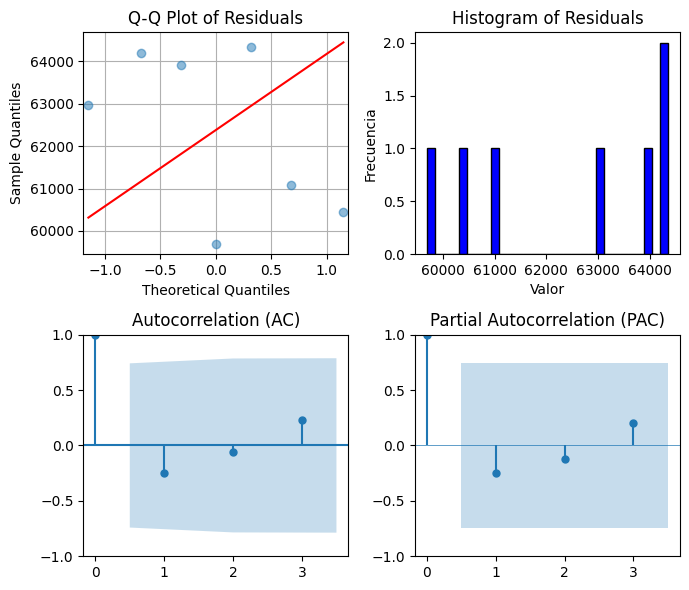

In [293]:
residuos = pd.DataFrame(list(set(yhat_7d) - set(test_7d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos del modelo ARIMA(1,2,1) para el horizonte de predicción de 7 días sugiere que los errores son estacionarios y no presentan correlaciones significativas entre sí. No obstante, tanto el gráfico cuantil-cuantil como el histograma no muestran evidencia clara de que los residuos se ajusten a una distribución normal. Para investigar más a fondo estas observaciones, se realizarán pruebas analíticas adicionales.

In [311]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.873, p=0.198
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [312]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -2.437728
p-value: 0.131370
Los residuos no son estacionarios (no se rechaza H0)


In [313]:
ljung_box = acorr_ljungbox(residuos, lags=[6], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][6])
print('p-value: %f' % ljung_box['lb_pvalue'][6])

p_value = ljung_box['lb_pvalue'][6]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 3.535932
p-value: 0.739183
Los residuos no están correlacionados (no se rechaza H0)


Los resultados para el modelo ARIMA(1,2,1) en el horizonte de 7 días revelan tanto aspectos positivos como áreas de mejora. La prueba de Shapiro indica que los errores se ajustan bien a una distribución gaussiana, lo que es un buen indicio de la normalidad de los residuos. Sin embargo, la prueba de Dickey-Fuller muestra que los residuos no son estacionarios, lo que sugiere que el modelo podría no estar capturando adecuadamente la dinámica temporal de los datos. La prueba de Ljung-Box indica que los residuos no están autocorrelacionados, lo cual es positivo. No obstante, el bajo valor del estadístico de Durbin-Watson (0.0019) sugiere una fuerte autocorrelación positiva en los residuos, lo que contrasta con la falta de autocorrelación reportada por Ljung-Box. En resumen, aunque el modelo muestra una distribución de errores adecuada, enfrenta problemas significativos en términos de estacionariedad y autocorrelación, lo que puede limitar su eficacia para el horizonte de predicción de 7 días.

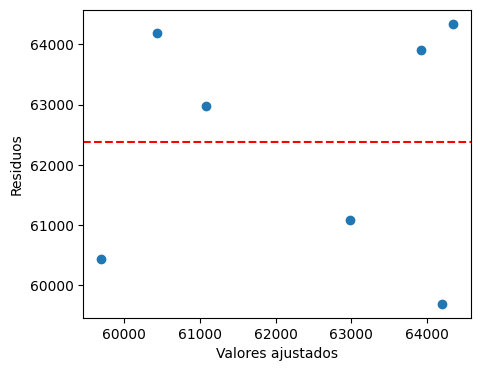

In [307]:
plt.scatter(yhat_7d, residuos)
plt.axhline(y=62377.773574, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

La gráfica de valores ajustados frente a los residuos no revela patrones que sugieran heterocedasticidad, lo cual es un indicio positivo de que la varianza de los errores es consistente a lo largo de las predicciones. Esto sugiere que, en términos de heterocedasticidad, el modelo ARIMA(1,2,1) está manejando bien la variabilidad en los residuos. Sin embargo, a pesar de la ausencia de heterocedasticidad, el modelo presenta deficiencias en otros aspectos, como la no estacionariedad de los residuos y problemas potenciales de autocorrelación, como se evidenció en las pruebas anteriores. Por lo tanto, aunque no se identifican problemas de heterocedasticidad, el modelo aún necesita ajustes para abordar la falta de estacionariedad y la posible autocorrelación en los residuos.

### Sin Rolling

In [308]:
pronostico = model_fit.forecast(steps=len(dates_7d))

In [310]:
forecast_accuracy(np.array(test_7d), np.array(pronostico), "7 días")

,MAE,MSE,MAPE,RMSE,R2
7 días,2307.686631,7.242658e+06,0.038151,2691.218591,-0.535628


Los índices de ajuste del modelo ARIMA(1,2,1) en una ventana de 7 días sin rolling indican un rendimiento deficiente. El MAE (2307.69) y el RMSE (2691.22) son elevados, lo que sugiere que los errores promedio y las desviaciones de las predicciones respecto a los valores reales son bastante altos. El MAPE (0.038) indica que el modelo comete errores significativos en relación con los valores reales. Además, el R² negativo (-0.54) sugiere que el modelo es menos efectivo que un modelo de referencia simple (como el promedio) en capturar la variabilidad de los datos. Estos resultados indican que el modelo ARIMA sin rolling no está funcionando bien para este horizonte de 7 días y no proporciona una representación precisa de los datos en este intervalo.

In [315]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.0,-0.5
pred,-0.5,1.0


In [316]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.491698
pred,-0.491698,1.000000


Los coeficientes de correlación entre los datos de prueba y los datos predichos para el modelo ARIMA en una ventana de 7 días sin rolling son negativos: Spearman (-0.50) y Pearson (-0.49). Estos valores sugieren una correlación negativa moderada, indicando que a medida que los valores predichos aumentan, los valores reales tienden a disminuir y viceversa. La correlación negativa también refuerza la idea de que el modelo ARIMA no está capturando bien la relación entre las predicciones y los datos reales. En conjunto con los resultados de las métricas de ajuste, estos hallazgos confirman que el modelo tiene un rendimiento deficiente en la predicción de los datos en este horizonte de 7 días.

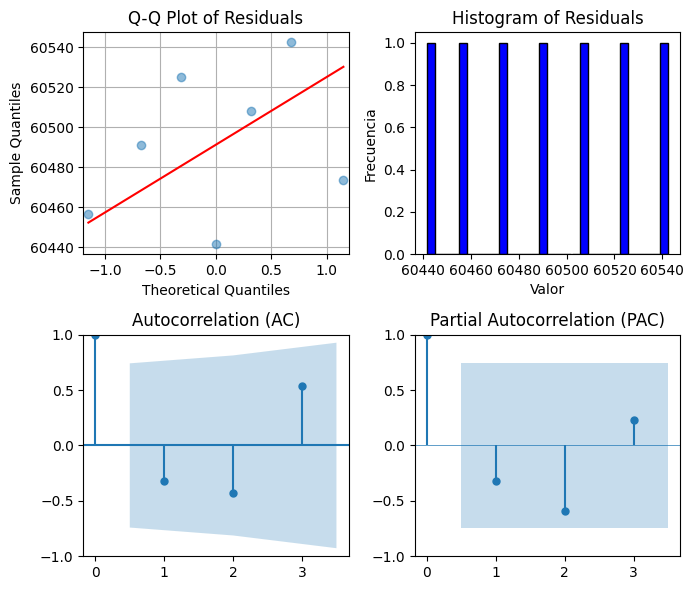

In [317]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_7d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos del modelo ARIMA(1,2,1) sin rolling y para el horizonte de predicción de 7 días sugiere que los errores son estacionarios y no presentan correlaciones significativas entre sí. No obstante, tanto el gráfico cuantil-cuantil como el histograma no muestran evidencia clara de que los residuos se ajusten a una distribución normal. Para investigar más a fondo estas observaciones, se realizarán pruebas analíticas adicionales.

In [318]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.975, p=0.929
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [319]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -3.622424
p-value: 0.005347
Los residuos son estacionarios (se rechaza H0)


In [322]:
ljung_box = acorr_ljungbox(residuos, lags=[6], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][6])
print('p-value: %f' % ljung_box['lb_pvalue'][6])

p_value = ljung_box['lb_pvalue'][6]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 10.271078
p-value: 0.113691
Los residuos no están correlacionados (no se rechaza H0)


Los resultados sugieren que el modelo ARIMA para el horizonte de 7 días sin rolling presenta algunas características positivas y negativas en términos de ajuste y cumplimiento de supuestos. La prueba de Shapiro indica que los errores se ajustan a una distribución normal, lo que es favorable para la normalidad de los residuos. La prueba de Dickey-Fuller muestra que los residuos son estacionarios, indicando que el modelo está capturando adecuadamente la estructura temporal de los datos en cuanto a estacionariedad. La prueba de Ljung-Box sugiere que los residuos no están autocorrelacionados, lo que es positivo para el ajuste del modelo.

Sin embargo, el muy bajo valor del estadístico de Durbin-Watson (7.6749e-07) es inusualmente cercano a cero, sugiriendo que los residuos podrían estar autocorrelacionados, lo que es inconsistente con la prueba de Ljung-Box que indica falta de autocorrelación. En conjunto, estos resultados sugieren que, a pesar de que el modelo cumple con varios supuestos, el valor atípico del estadístico de Durbin-Watson podría indicar problemas con la autocorrelación de los residuos que requieren una revisión más detallada.

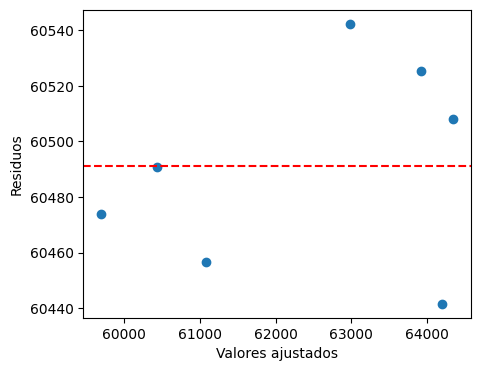

In [326]:
plt.scatter(pronostico, residuos)
plt.axhline(y=60491.187055, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

La ausencia de patrones en el gráfico de valores ajustados versus residuos indica que no hay evidencia de heterocedasticidad en el modelo. Esto sugiere que la varianza de los errores es relativamente constante a lo largo del rango de las predicciones, lo cual es un buen indicio de que el modelo ARIMA no presenta problemas significativos de variabilidad en los errores a diferentes niveles de predicción. Este hallazgo es positivo, ya que confirma que el modelo no está mostrando signos de errores que aumenten o disminuyan sistemáticamente con los valores ajustados. Sin embargo, es importante considerar esta observación junto con otros resultados del análisis para obtener una visión completa del desempeño del modelo.

### Resultado general: Horizonte de 7 días

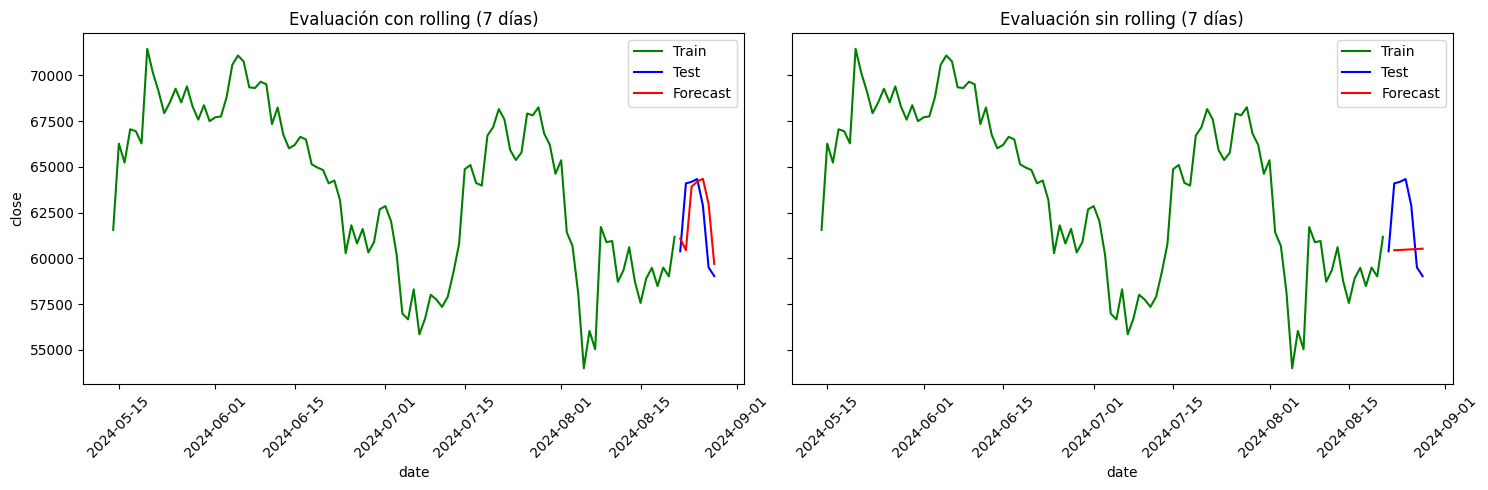

In [333]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_7d, y=test_7d, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_7d, y=yhat_7d, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (7 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_7d, y=test_7d, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_7d, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (7 días)')

plt.tight_layout()
plt.show()

En la ventana de 7 días, el modelo ARIMA(1,2,1) con rolling muestra un ajuste moderado, con errores normales y sin indicios de heterocedasticidad, aunque presenta problemas de no estacionariedad. En contraste, el modelo sin rolling tiene un desempeño deficiente, con un R² negativo y errores altos, a pesar de que los residuos son normales y estacionarios. La falta de autocorrelación en ambos modelos no compensa las debilidades generales, siendo el modelo con rolling superior en términos de ajuste y cumplimiento de supuestos.

## Conclusión del modelo ARIMA(1,2,1)

El modelo ARIMA(1,2,1) muestra un mejor desempeño con rolling en comparación con el modelo sin rolling en todos los horizontes de predicción. El enfoque con rolling es más flexible y ajustado a la estructura temporal de los datos, mostrando un ajuste más preciso y consistente, especialmente en los horizontes de 21 y 28 días. En el horizonte de 7 días, aunque el modelo con rolling sigue siendo superior, ambos enfoques presentan limitaciones significativas. El uso de rolling permite un ajuste más eficaz, mientras que el modelo sin rolling tiene un desempeño deficiente en todos los horizontes, subrayando la necesidad de ajustes adicionales.

## Modelo ARIMA(4,1,4)

In [32]:
best_order = (4,1,4)
model2 = ARIMA(train, order=best_order)
model_fit = model2.fit()

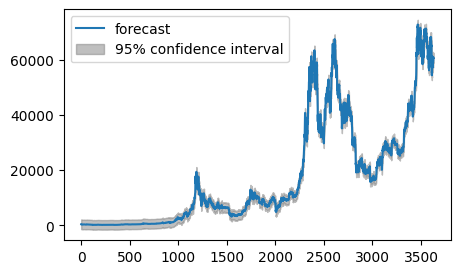

In [27]:
plt.rcParams.update({'figure.figsize': (5,3)})
fig, ax = plt.subplots();
plot_predict(model_fit, 2, ax=ax);
plt.show();

## Horizonte de 28 días

### Rolling

In [33]:
test_4wl = test_4w.tolist()
yhat_4w  = arima_rolling(train.tolist(), test_4wl, order = (4,1,4))

predicted=63736.549619, expected=64178.992188
predicted=64219.785606, expected=64333.542969
predicted=64488.927027, expected=62880.660156
predicted=62860.493483, expected=59504.132812
predicted=59913.454657, expected=59027.625000
predicted=58600.702908, expected=59388.179688
predicted=59464.288359, expected=59119.476562
predicted=58661.870469, expected=58969.898438
predicted=59451.433207, expected=57325.488281
predicted=57025.061230, expected=59112.480469
predicted=59308.475552, expected=57431.023438
predicted=57689.411193, expected=57971.539062
predicted=57947.250761, expected=56160.488281
predicted=56116.937583, expected=53948.753906
predicted=53939.364426, expected=54139.687500
predicted=53867.556495, expected=54841.566406
predicted=54906.595809, expected=57019.535156
predicted=56976.721913, expected=57648.710938
predicted=57933.523132, expected=57343.171875
predicted=57426.290576, expected=58127.011719
predicted=58103.047909, expected=60571.300781
predicted=60311.459593, expected=6

In [62]:
forecast_accuracy(np.array(test_4wl), np.array(yhat_4w), "28 días")

,MAE,MSE,MAPE,RMSE,R2
28 días,1162.370768,2.063863e+06,0.019749,1436.615278,0.718954


El modelo ARIMA(4,1,4) evaluado con rolling para un horizonte de 28 días muestra un buen desempeño. Los índices de error, como el MAE, MSE y RMSE, son bajos, lo que indica precisión en las predicciones. El MAPE también refleja un porcentaje de error relativamente bajo. Estos resultados, junto con un R² positivo, sugieren que el modelo se ajusta bien a los datos en este horizonte y que la evaluación con rolling ha permitido un rendimiento consistente y flexible en las predicciones.

In [63]:
df_cor = pd.DataFrame({
    'Obs': test_4wl,
    'pred': yhat_4w
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.811166
pred,0.811166,1.000000


In [64]:
df_cor = pd.DataFrame({
    'Obs': test_4wl,
    'pred': yhat_4w
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.863351
pred,0.863351,1.000000


Las correlaciones de Spearman y Pearson entre los datos de prueba y las predicciones del modelo ARIMA(4,1,4) evaluado con rolling son altas, con valores de 0.81 y 0.86, respectivamente. Esto indica una fuerte relación tanto en términos de orden como en linealidad entre las predicciones y los datos reales, lo que refuerza la calidad del ajuste del modelo y su capacidad para capturar con precisión las tendencias subyacentes en este horizonte de 28 días.

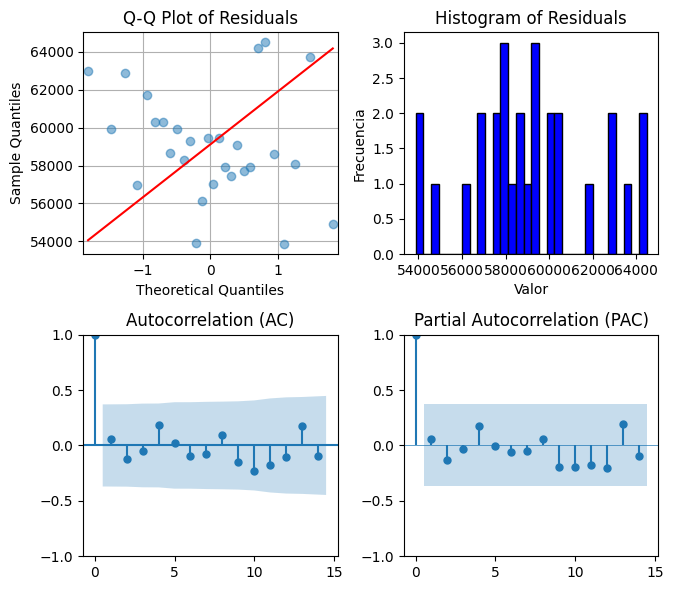

In [65]:
residuos = pd.DataFrame(list(set(yhat_4w) - set(test_4wl)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos del modelo ARIMA(4,1,4) para el horizonte de 28 días con rolling revela que el histograma sugiere que los errores del modlode se aproximan a una distribución gaussiana, mientras que el gráfico cuantil-cuantil no respalda esta suposición. Además, el gráfico de autocorrelación indica que los residuos son estacionarios y el gráfico de correlación parcial sugiere que no hay correlación significativa entre los errores del modelo. Se procederá a realizar pruebas analíticas adicionales para confirmar estas observaciones y evaluar más a fondo el cumplimiento de los supuestos del modelo.

In [66]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.963, p=0.405
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [67]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -3.845687
p-value: 0.002473
Los residuos son estacionarios (se rechaza H0)


In [68]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 6.373931
p-value: 0.782930
Los residuos no están correlacionados (no se rechaza H0)


Las pruebas analíticas realizadas sobre los residuos del modelo ARIMA(4,1,4) confirman varias observaciones clave. La prueba de Shapiro indica que los errores se aproximan a una distribución normal, apoyando la evidencia visual proporcionada por el histograma. La prueba de Dickey-Fuller sugiere que los residuos son estacionarios, lo que es consistente con el gráfico de autocorrelación. Finalmente, la prueba de Ljung-Box confirma que los residuos no están correlacionados, validando lo observado en el gráfico de correlación parcial. Estos resultados refuerzan que el modelo cumple con los principales supuestos de normalidad, estacionariedad y ausencia de correlación entre los errores.

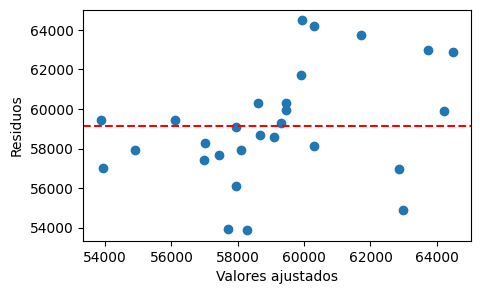

In [69]:
plt.scatter(yhat_4w, residuos)
plt.axhline(y=59116.592196, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

El gráfico de residuos frente a los valores ajustados no muestra patrones evidentes que sugieran la presencia de heterocedasticidad, lo que indica que la varianza de los errores se mantiene constante a lo largo de las predicciones del modelo ARIMA(4,1,4). Este resultado es positivo, ya que la ausencia de heterocedasticidad sugiere que el modelo no presenta problemas de variabilidad no capturada en los errores.

### Sin rolling

In [45]:
pronostico = model_fit.forecast(steps=len(dates_4w))

In [46]:
forecast_accuracy(np.array(test_4w), np.array(pronostico), "28 días")

,MAE,MSE,MAPE,RMSE,R2
28 días,4893.743586,3.076287e+07,0.076556,5546.428589,-3.189118


Para el modelo ARIMA(4,1,4) sin la técnica de rolling, los índices de ajuste indican un rendimiento deficiente en el horizonte de 28 días. Las métricas como el MAE, MSE, MAPE y RMSE son considerablemente altas, lo que refleja errores de predicción sustanciales y una baja precisión en el ajuste. Además, el valor negativo del R² sugiere que el modelo no solo es ineficaz en capturar la variabilidad de los datos, sino que sus predicciones son peores que simplemente utilizar la media de los datos como referencia. Esto señala que el modelo sin rolling no ha logrado captar adecuadamente la estructura temporal de los datos.

In [47]:
df_cor = pd.DataFrame({
    'Obs': test_4w,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,-0.263126
pred,-0.263126,1.000000


In [48]:
df_cor = pd.DataFrame({
    'Obs': test_4w,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.235158
pred,-0.235158,1.000000


La correlación de Spearman y Pearson entre los datos de prueba y las predicciones del modelo ARIMA(4,1,4) sin rolling es negativa (-.26 y -.23, respectivamente). Estos valores indican una relación débil y desfavorable entre los datos reales y las predicciones del modelo. Esto sugiere que el modelo no está capturando adecuadamente las tendencias y patrones en los datos, lo que contribuye a su bajo rendimiento general y a la ineficacia en la predicción.

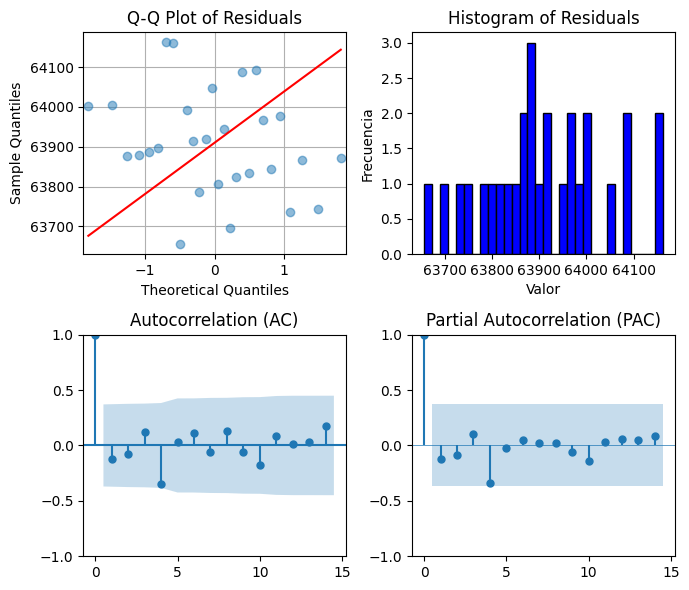

In [49]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_4wl)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos del modelo ARIMA(4,1,4) sin rolling muestra que el gráfico cuantil-cuantil y el histograma no proporcionan evidencia clara sobre la normalidad de los residuos. No obstante, las gráficas de autocorrelación y autocorrelación parcial sugieren que los errores son estacionarios y no están significativamente correlacionados. Se realizarán pruebas analíticas adicionales para confirmar estas observaciones y evaluar más a fondo el ajuste del modelo.

In [50]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.982, p=0.901
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [51]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -5.682948
p-value: 0.000001
Los residuos son estacionarios (se rechaza H0)


In [52]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 8.379951
p-value: 0.591776
Los residuos no están correlacionados (no se rechaza H0)


Aunque las inspecciones visuales, como el gráfico cuantil-cuantil y el histograma, no proporcionan una evidencia clara de que los residuos se distribuyan normalmente, las pruebas analíticas confirmaron que el modelo ARIMA(4,1,4) sin rolling cumple con los supuestos clave. La prueba de Shapiro indica que los errores se aproximan a una distribución normal, mientras que las pruebas de Dickey-Fuller y Ljung-Box confirman que los residuos son estacionarios y no presentan autocorrelación significativa. Esto sugiere que, a pesar de las observaciones visuales, el modelo es adecuado en términos de los supuestos fundamentales requeridos para su validez.

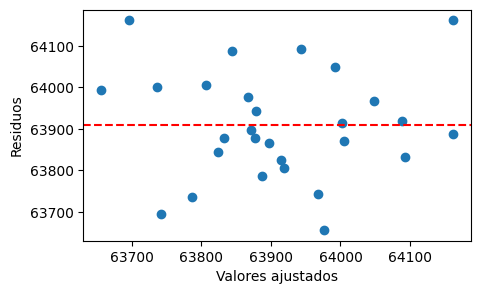

In [55]:
plt.scatter(pronostico, residuos)
plt.axhline(y=63909.909911, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

El gráfico de residuos frente a los valores ajustados no muestra tendencias que sugieran heterocedasticidad, indicando que la varianza de los errores parece ser constante a lo largo de las predicciones. Esto es un indicio positivo, ya que sugiere que el modelo ARIMA(4,1,4) sin rolling no presenta problemas evidentes de variabilidad en los errores en función de los valores ajustados. En conjunto con los resultados de las pruebas analíticas, esta observación refuerza la validez del modelo en cuanto a la homogeneidad de la varianza de los errores.

### Resultado general: Horizonte de 28 días

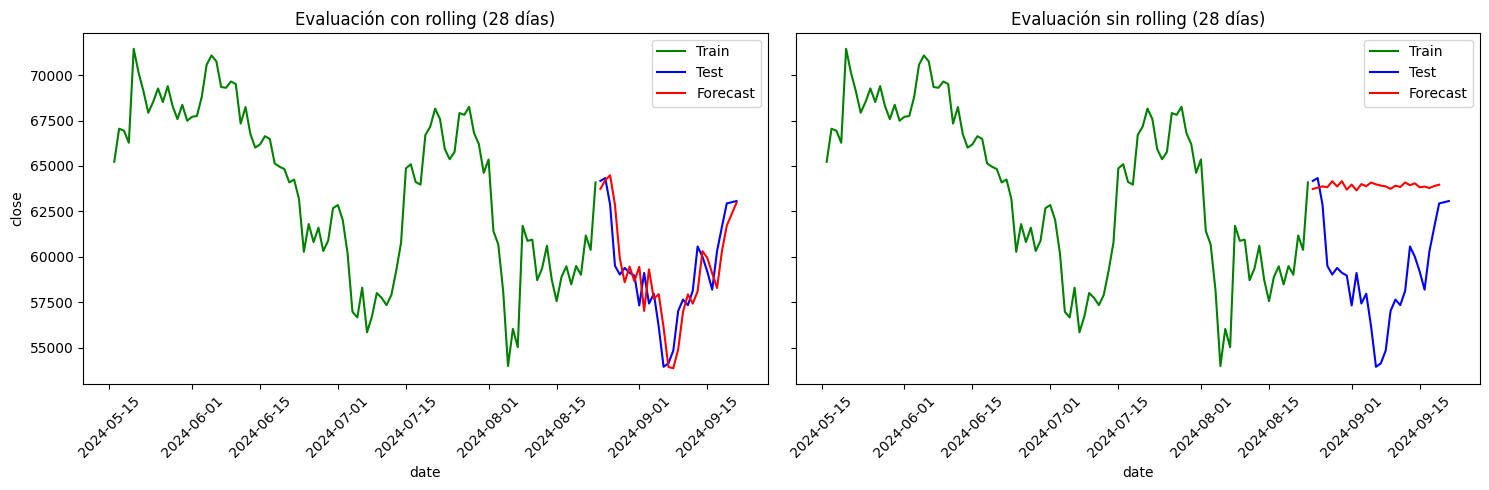

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_4w, y=test_4wl, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_4w, y=yhat_4w, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (28 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_4w, y=test_4w, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_4w, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (28 días)')

plt.tight_layout()
plt.show()

En la ventana de 28 días, el modelo ARIMA(4,1,4) muestra un rendimiento notablemente superior cuando se utiliza la técnica de rolling en comparación con la evaluación sin rolling. Con rolling, el modelo exhibe un ajuste sólido, evidenciado por errores relativamente bajos y un buen índice de ajuste, además de cumplir con los supuestos de normalidad, estacionariedad y ausencia de autocorrelación en los errores. Por otro lado, sin rolling, el modelo presenta un ajuste deficiente, con errores significativamente altos y un R² negativo, indicando una capacidad limitada para capturar la variabilidad de los datos y reflejar la estructura temporal adecuada. En resumen, el uso de rolling ofrece una evaluación más robusta y ajustada a las características temporales de los datos, destacando la necesidad de mejorar el ajuste del modelo sin esta técnica.

## Horizonte de 21 días

In [70]:
test_21d = CL_df.close[train_size:train_size + 21] 
dates_21d = CL_df.date[train_size:train_size + 21]

### Rolling

In [71]:
test_21d = test_21d.tolist()
yhat_21d  = arima_rolling(train.tolist(), test_21d, order = (4,1,4))

predicted=63736.549619, expected=64178.992188
predicted=64219.785606, expected=64333.542969
predicted=64488.927027, expected=62880.660156
predicted=62860.493483, expected=59504.132812
predicted=59913.454657, expected=59027.625000
predicted=58600.702908, expected=59388.179688
predicted=59464.288359, expected=59119.476562
predicted=58661.870469, expected=58969.898438
predicted=59451.433207, expected=57325.488281
predicted=57025.061230, expected=59112.480469
predicted=59308.475552, expected=57431.023438
predicted=57689.411193, expected=57971.539062
predicted=57947.250761, expected=56160.488281
predicted=56116.937583, expected=53948.753906
predicted=53939.364426, expected=54139.687500
predicted=53867.556495, expected=54841.566406
predicted=54906.595809, expected=57019.535156
predicted=56976.721913, expected=57648.710938
predicted=57933.523132, expected=57343.171875
predicted=57426.290576, expected=58127.011719
predicted=58103.047909, expected=60571.300781


In [72]:
forecast_accuracy(np.array(test_21d), np.array(yhat_21d), "21 días")

,MAE,MSE,MAPE,RMSE,R2
21 días,1233.021457,2.328123e+06,0.021031,1525.818958,0.691701


Para el modelo ARIMA(4,1,4) en la ventana de 21 días con rolling, las métricas de ajuste indican un rendimiento positivo. El MAE y el MSE sugieren errores relativamente bajos en las predicciones, lo que implica que el modelo se ajusta bien a los datos observados. El MAPE, con un valor bajo, indica que el modelo tiene un buen desempeño en términos de precisión relativa de las predicciones. El RMSE, aunque mayor que en la ventana de 28 días, sigue siendo razonable, reflejando errores de predicción moderados. Finalmente, el R² positivo señala que el modelo es capaz de capturar una proporción significativa de la variabilidad en los datos, lo que refuerza la capacidad del modelo para ajustarse adecuadamente a las series temporales en este horizonte de predicción.

In [88]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': yhat_21d
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.763636
pred,0.763636,1.000000


In [89]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': yhat_21d
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.863032
pred,0.863032,1.000000


Las correlaciones entre los datos de prueba y las predicciones para el modelo ARIMA(4,1,4) en la ventana de 21 días muestran resultados positivos. La correlación de Spearman de 0.76 sugiere una fuerte relación monotónica entre los valores reales y los predichos, indicando que las predicciones del modelo siguen la tendencia general de los datos observados. Por otro lado, la correlación de Pearson de 0.86 refuerza esta observación al mostrar una alta relación lineal, lo que significa que el modelo ARIMA(4,1,4) en esta ventana de 21 días logra una representación precisa y coherente de las variaciones en los datos reales. Estas correlaciones positivas son indicativas de un buen ajuste del modelo a los datos de prueba y refuerzan la validez de las predicciones realizadas.

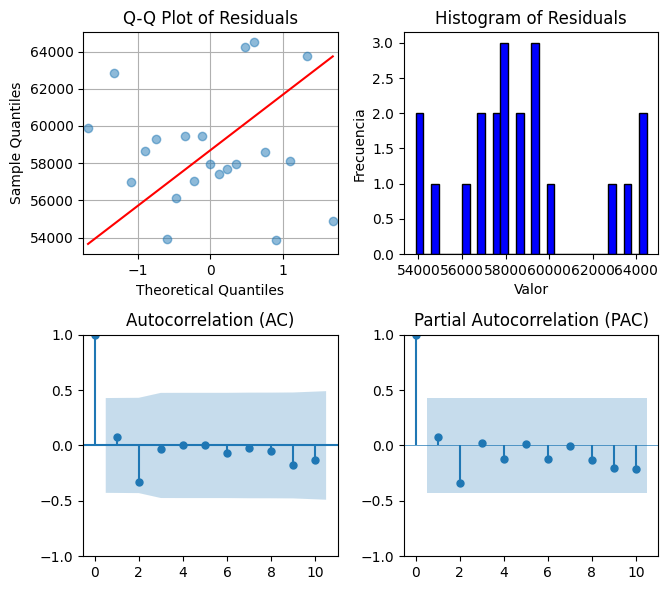

In [75]:
residuos = pd.DataFrame(list(set(yhat_21d) - set(test_21d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

El análisis del modelo ARIMA(4,1,4) en la ventana de 21 días muestra que, a pesar de que los gráficos cuantil-cuantil y el histograma no evidencian una clara normalidad en los residuos, las gráficas de autocorrelación y autocorrelación parcial sugieren que los errores son estacionarios y no presentan autocorrelación significativa. Se procederá a realizar pruebas analíticas adicionales para investigar más a fondo estas observaciones.

In [76]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.929, p=0.130
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [77]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -4.382809
p-value: 0.000318
Los residuos son estacionarios (se rechaza H0)


In [78]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 5.238391
p-value: 0.874695
Los residuos no están correlacionados (no se rechaza H0)


Las pruebas analíticas para el modelo ARIMA(4,1,4) en la ventana de 21 días confirman los hallazgos preliminares. La prueba de Shapiro-Wilk indica que los residuos se aproximan a una distribución normal, mientras que la prueba de Dickey-Fuller muestra que son estacionarios. Además, la prueba de Ljung-Box revela que los residuos no están correlacionados. Estos resultados respaldan la validez del modelo en cuanto a los supuestos fundamentales de normalidad, estacionariedad y ausencia de autocorrelación.

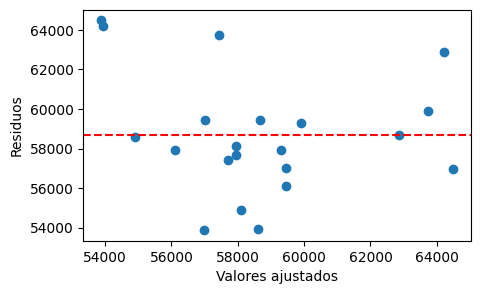

In [81]:
plt.scatter(yhat_21d, residuos)
plt.axhline(y=58697.035329, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

El gráfico de datos ajustados frente a los residuos no revela patrones que sugieran heterocedasticidad. Esto indica que la varianza de los errores se mantiene constante a lo largo del rango de predicciones, apoyando la estabilidad del modelo en términos de la variabilidad de los errores. En conjunto con los resultados de las pruebas analíticas, este hallazgo sugiere que el modelo ARIMA(4,1,4) en la ventana de 21 días maneja adecuadamente el supuesto de homocedasticidad.

### Sin Rolling

In [84]:
pronostico = model_fit.forecast(steps=len(dates_21d))

In [85]:
forecast_accuracy(np.array(test_21d), np.array(pronostico), "21 días")

,MAE,MSE,MAPE,RMSE,R2
21 días,5475.162586,3.677142e+07,0.085643,6063.944078,-3.869412


Para el modelo ARIMA(4,1,4) en la ventana de 21 días sin la técnica de rolling, las métricas de ajuste indican un rendimiento deficiente. El MAE y el RMSE son considerablemente altos, lo que sugiere errores de predicción elevados. El MAPE también es elevado, indicando que el modelo tiene dificultades para capturar la magnitud relativa de los errores. El valor negativo del R² señala que el modelo no solo es ineficaz en predecir los valores, sino que sus predicciones son peores que las de un modelo que simplemente predice la media de los datos. Esto sugiere que el modelo sin rolling no es adecuado para esta ventana de predicción y que su capacidad para ajustarse a la serie temporal es limitada.

In [90]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,-0.319481
pred,-0.319481,1.000000


In [93]:
df_cor = pd.DataFrame({
    'Obs': test_21d,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.295754
pred,-0.295754,1.000000


Las correlaciones entre los datos de prueba y las predicciones para el modelo ARIMA(4,1,4) en la ventana de 21 días sin rolling, con valores de -0.32 para Spearman y -0.30 para Pearson, indican una relación débil y negativa. Estos resultados sugieren que el modelo tiene dificultades para capturar adecuadamente la relación entre los valores reales y las predicciones, con una correlación negativa que refleja una tendencia a predecir valores que se desvían en sentido opuesto a los datos reales. Esto refuerza la conclusión de que el modelo no es efectivo en este contexto y requiere ajustes significativos para mejorar su desempeño predictivo.

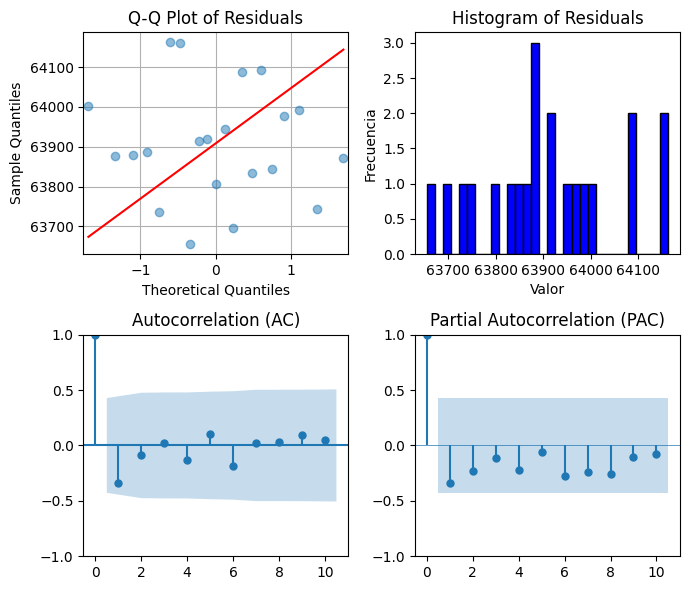

In [98]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_21d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos del modelo ARIMA(4,1,4) en la ventana de 21 días sin rolling muestra que tanto el histograma como el gráfico cuantil-cuantil no brindan evidencia clara de que los errores se ajusten a una distribución normal. Sin embargo, el gráfico de autocorrelación y el gráfico de autocorrelación parcial sugieren que los errores son estacionarios y no presentan una correlación significativa. Para confirmar estas observaciones y evaluar a fondo los supuestos del modelo, se realizarán pruebas analíticas adicionales.

In [99]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.970, p=0.737
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [100]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -2.248037
p-value: 0.189275
Los residuos no son estacionarios (no se rechaza H0)


In [101]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 5.520155
p-value: 0.853840
Los residuos no están correlacionados (no se rechaza H0)


En general, el modelo ARIMA(4,1,4) en la ventana de 21 días sin rolling muestra que los residuos son aproximadamente normales y no presentan autocorrelación, lo que es positivo. Sin embargo, la falta de estacionariedad en los residuos sugiere que el modelo podría no estar capturando adecuadamente las dinámicas temporales de los datos, lo que indica la necesidad de considerar ajustes adicionales para mejorar su rendimiento.

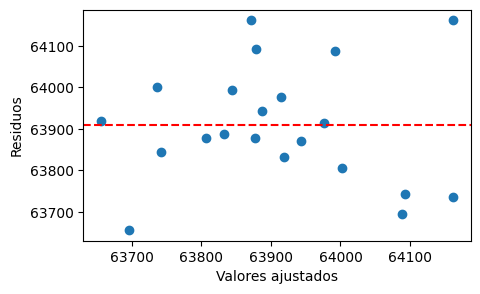

In [104]:
plt.scatter(pronostico, residuos)
plt.axhline(y=63908.666161, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

El gráfico de residuos contra valores ajustados revela una tendencia parabólica descendente, lo que sugiere la presencia de heterocedasticidad. Esto indica que la variabilidad de los residuos cambia en función del nivel de los valores ajustados, sugiriendo que el modelo podría no estar capturando adecuadamente la estructura de la variabilidad en los datos. Este hallazgo sugiere que se deben considerar ajustes adicionales para abordar la heterocedasticidad y mejorar la precisión del modelo.

### Resultado general: Horizonte de 21 días

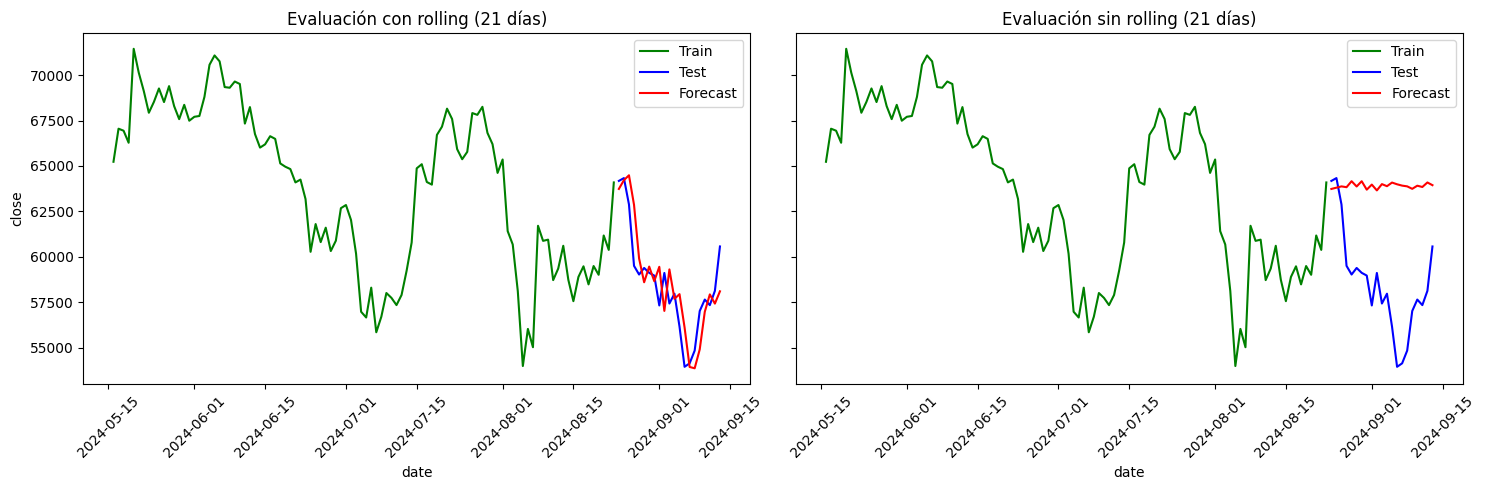

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_21d, y=test_21d, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_21d, y=yhat_21d, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (21 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_21d, y=test_21d, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_21d, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (21 días)')

plt.tight_layout()
plt.show()

Para el modelo ARIMA(4,1,4) en la ventana de 21 días, el enfoque con rolling muestra un rendimiento superior en comparación con el enfoque sin rolling, evidenciado por errores más bajos y un coeficiente de determinación positivo, junto con una fuerte correlación entre los datos reales y las predicciones. Los residuos cumplen con los supuestos de normalidad, estacionariedad y ausencia de autocorrelación. Por otro lado, el modelo sin rolling presenta errores más altos y un ajuste deficiente, con indicios de heterocedasticidad. En resumen, el uso de rolling ofrece una evaluación más flexible y ajustada a las características temporales de los datos.

## Horizonte de 14 días

In [106]:
test_14d = CL_df.close[train_size:train_size + 14] 
dates_14d = CL_df.date[train_size:train_size + 14]

### Rolling

In [107]:
test_14d = test_14d.tolist()
yhat_14d  = arima_rolling(train.tolist(), test_14d, order = (4,1,4))

predicted=63736.549619, expected=64178.992188
predicted=64219.785606, expected=64333.542969
predicted=64488.927027, expected=62880.660156
predicted=62860.493483, expected=59504.132812
predicted=59913.454657, expected=59027.625000
predicted=58600.702908, expected=59388.179688
predicted=59464.288359, expected=59119.476562
predicted=58661.870469, expected=58969.898438
predicted=59451.433207, expected=57325.488281
predicted=57025.061230, expected=59112.480469
predicted=59308.475552, expected=57431.023438
predicted=57689.411193, expected=57971.539062
predicted=57947.250761, expected=56160.488281
predicted=56116.937583, expected=53948.753906


In [108]:
forecast_accuracy(np.array(test_14d), np.array(yhat_14d), "14 días")

,MAE,MSE,MAPE,RMSE,R2
14 días,1298.20457,2.575278e+06,0.021764,1604.767224,0.67182


Para el modelo ARIMA(4,1,4) en la ventana de 14 días con rolling, los índices de ajuste muestran un rendimiento sólido. Las métricas como el MAE, MSE, y RMSE son favorables, indicando errores relativamente bajos en las predicciones. El R² positivo sugiere que el modelo captura bien la variabilidad de los datos. En conjunto, estos resultados reflejan un buen ajuste del modelo, con el enfoque de rolling proporcionando una evaluación ajustada a las características temporales de los datos.

In [109]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': yhat_14d
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,0.740659
pred,0.740659,1.000000


In [110]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': yhat_14d
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.863394
pred,0.863394,1.000000


Para el modelo ARIMA(4,1,4) en la ventana de 14 días con rolling, las correlaciones de Spearman y Pearson entre los datos de prueba y los predicciones son altas (.74 y .86, respectivamente). Estas altas correlaciones indican una fuerte relación entre los valores predichos y los datos reales, lo que respalda la eficacia del modelo en capturar la estructura temporal y variabilidad de los datos. Esto sugiere que el modelo, con la técnica de rolling, está realizando buenas predicciones y ajustándose adecuadamente a los datos en este horizonte de 14 días.

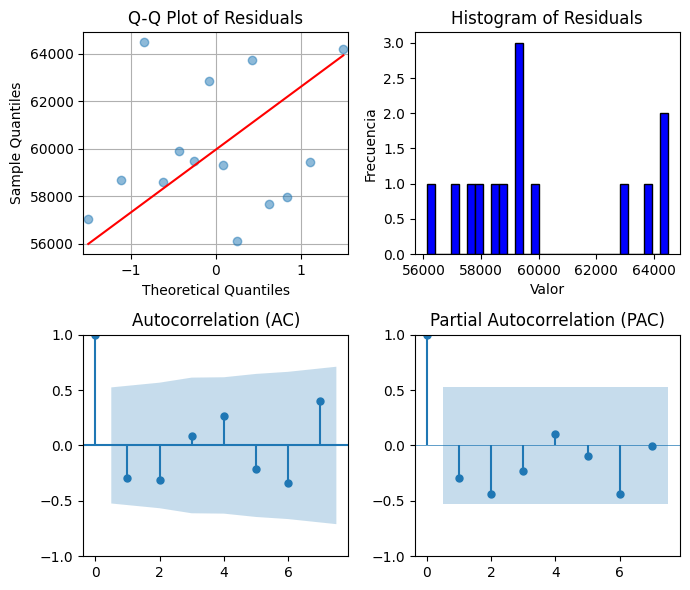

In [111]:
residuos = pd.DataFrame(list(set(yhat_14d) - set(test_14d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los errores muestra que el gráfico cuantil-cuantil y el histograma no sugieren que los errores se aproximen a una distribución normal. Sin embargo, los gráficos de autocorrelación y autocorrelación parcial indican que los errores son estacionarios y que no presentan correlaciones fuertes entre sí. Se realizarán múltiples pruebas analíticas adicionales para confirmar estas observaciones y asegurar que los supuestos del modelo se cumplen adecuadamente.

In [112]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.894, p=0.093
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [113]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -2.576577
p-value: 0.097936
Los residuos no son estacionarios (no se rechaza H0)


In [114]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 15.914628
p-value: 0.102102
Los residuos no están correlacionados (no se rechaza H0)


A pesar de que la prueba de Shapiro-Wilk indica que los residuos se aproximan a una distribución normal y la prueba de Ljung-Box muestra que los residuos no están correlacionados, la prueba de Dickey-Fuller revela que los residuos no son estacionarios. Estos resultados sugieren que, aunque el modelo cumple con algunos supuestos importantes, como la normalidad de los residuos y la ausencia de autocorrelación, persiste un problema con la estacionariedad. Este hallazgo resalta la necesidad de ajustar el modelo para abordar la falta de estacionariedad y mejorar su rendimiento en el horizonte de 14 días.

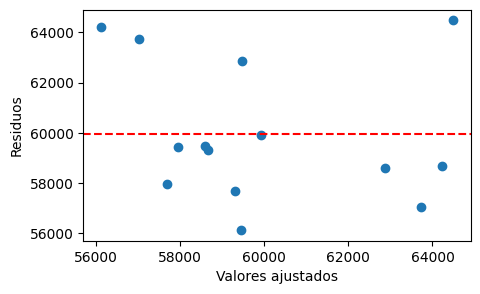

In [117]:
plt.scatter(yhat_14d, residuos)
plt.axhline(y=59963.188690, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

El gráfico de residuos frente a valores ajustados no revela tendencias que sugieran heterocedasticidad. Esto indica que, a nivel visual, no hay evidencia de que la variabilidad de los residuos cambie sistemáticamente con los valores ajustados, lo cual es un buen signo para la estabilidad del modelo en términos de homocedasticidad.

### Sin Rolling

In [118]:
pronostico = model_fit.forecast(steps=len(dates_14d))

In [119]:
forecast_accuracy(np.array(test_14d), np.array(pronostico), "14 días")

,MAE,MSE,MAPE,RMSE,R2
14 días,4809.507935,3.008555e+07,0.075205,5485.029685,-2.833942


Para el modelo ARIMA(4,1,4) sin rolling en la ventana de 14 días, las métricas de ajuste indican un desempeño deficiente. Los valores elevados de MAE, MSE y RMSE sugieren que el modelo presenta errores de predicción significativos. Además, el R² negativo confirma que el modelo no logra capturar adecuadamente la variabilidad de los datos, resultando en un ajuste inadecuado. En comparación con el modelo con rolling, este enfoque no proporciona un ajuste preciso ni efectivo para el horizonte de 14 días.

In [120]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,-0.498901
pred,-0.498901,1.000000


In [121]:
df_cor = pd.DataFrame({
    'Obs': test_14d,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.455133
pred,-0.455133,1.000000


Para el modelo ARIMA(4,1,4) sin rolling en la ventana de 14 días, las correlaciones de Spearman y Pearson entre los datos de prueba y las predicciones son negativas y moderadamente bajas. Estas correlaciones sugieren una relación inversa entre los datos reales y las predicciones del modelo, indicando que el modelo no está capturando bien la estructura de los datos. La debilidad en ambas correlaciones refuerza la conclusión de que el modelo sin rolling tiene un rendimiento deficiente en este horizonte de predicción.

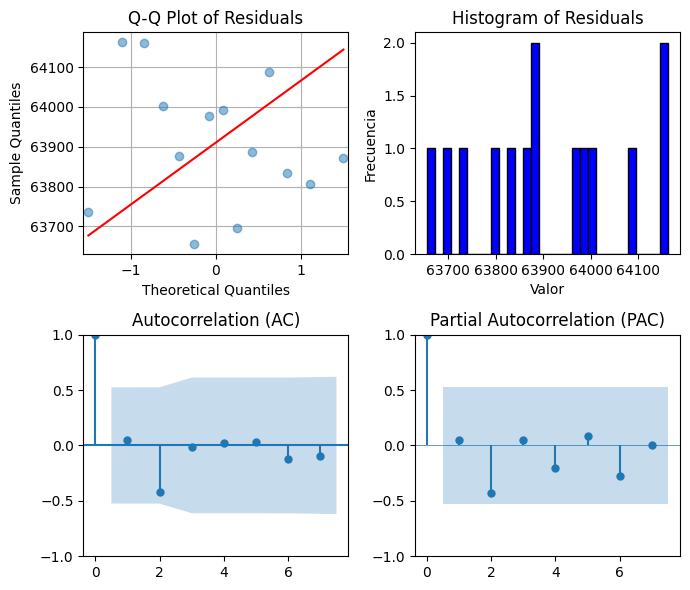

In [122]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_14d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos revela que el gráfico cuantil-cuantil y el histograma no sugieren que los errores se aproximen a una distribución normal, mientras que los gráficos de autocorrelación y autocorrelación parcial indican que los errores son estacionarios y no muestran correlaciones significativas. Estos resultados serán corroborados mediante pruebas analíticas adicionales.

In [123]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.959, p=0.706
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [124]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -3.617464
p-value: 0.005436
Los residuos son estacionarios (se rechaza H0)


In [125]:
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][10])
print('p-value: %f' % ljung_box['lb_pvalue'][10])

p_value = ljung_box['lb_pvalue'][10]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 9.678062
p-value: 0.469177
Los residuos no están correlacionados (no se rechaza H0)


Los resultados de las pruebas analíticas confirman que los residuos del modelo cumplen con los supuestos fundamentales. La prueba de Shapiro-Wilk indica que los residuos se aproximan a una distribución normal, mientras que la prueba de Dickey-Fuller confirma que los residuos son estacionarios. Además, la prueba de Ljung-Box revela que no hay correlación significativa entre los residuos, apoyando la validez del modelo en términos de estos supuestos.

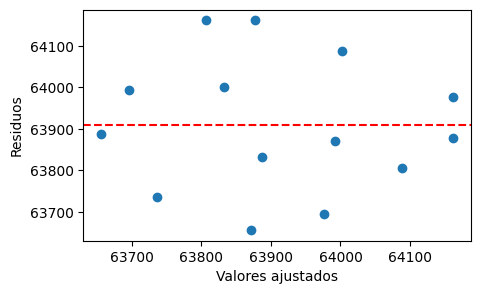

In [128]:
plt.scatter(pronostico, residuos)
plt.axhline(y=63910.407270, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

El gráfico de valores ajustados versus errores no revela ninguna tendencia evidente que sugiera heterocedasticidad. Esto indica que la variabilidad de los errores es constante a lo largo de los valores ajustados, lo que es un buen signo de que el modelo está capturando adecuadamente la estructura de los datos sin presentar problemas de heterocedasticidad.

### Resultado general: Horizonte de 14 días

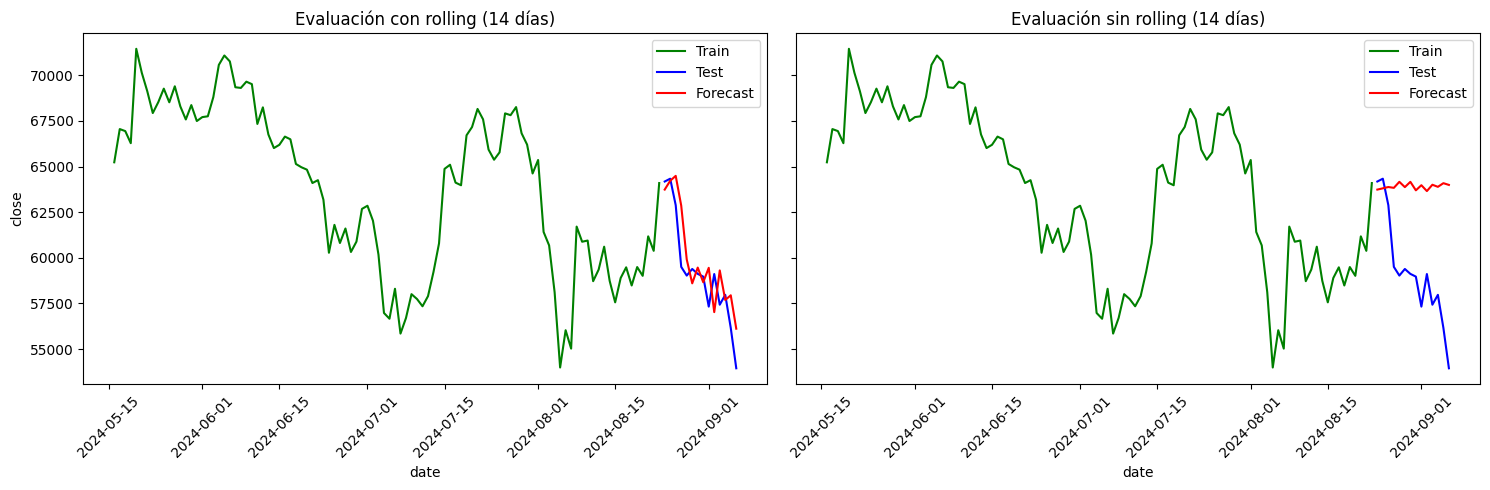

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_14d, y=test_14d, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_14d, y=yhat_14d, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (14 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_14d, y=test_14d, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_14d, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (14 días)')

plt.tight_layout()
plt.show()

En la ventana de 14 días, el modelo ARIMA(4,1,4) con rolling demuestra un rendimiento superior en comparación con el modelo sin rolling. Las métricas de ajuste, como MAE, MSE, y RMSE, indican un mejor desempeño del modelo con rolling, y las correlaciones entre los datos de prueba y las predicciones son significativamente más altas. Además, el análisis visual de los residuos y las pruebas analíticas confirman que los errores cumplen con los supuestos de normalidad, estacionariedad y ausencia de correlación. Por otro lado, el modelo sin rolling presenta errores más altos y correlaciones negativas, sugiriendo un ajuste deficiente y menor capacidad para capturar la estructura temporal de los datos. Aunque el modelo con rolling es más flexible y se ajusta mejor a los datos, ambos enfoques indican la necesidad de ajustes adicionales para mejorar la precisión general.

## Horizonte de 7 días

In [130]:
test_7d = CL_df.close[train_size:train_size + 7] 
dates_7d = CL_df.date[train_size:train_size + 7]

### Rolling

In [131]:
test_7d = test_7d.tolist()
yhat_7d  = arima_rolling(train.tolist(), test_7d, order = (4,1,4))

predicted=63736.549619, expected=64178.992188
predicted=64219.785606, expected=64333.542969
predicted=64488.927027, expected=62880.660156
predicted=62860.493483, expected=59504.132812
predicted=59913.454657, expected=59027.625000
predicted=58600.702908, expected=59388.179688
predicted=59464.288359, expected=59119.476562


In [132]:
forecast_accuracy(np.array(test_7d), np.array(yhat_7d), "7 días")

,MAE,MSE,MAPE,RMSE,R2
7 días,1076.992244,2.226298e+06,0.017295,1492.078343,0.575648


El modelo ARIMA(4,1,4) con rolling para una ventana de 7 días muestra un ajuste general positivo. Las métricas de ajuste indican que el modelo tiene errores relativamente bajos en términos de MAE y RMSE, lo que sugiere que las predicciones están cerca de los valores reales. El MAPE también es bajo, lo que indica que el modelo tiene un buen desempeño en términos de precisión relativa. El R² positivo muestra que el modelo explica una parte significativa de la variabilidad en los datos. En conjunto, estos resultados sugieren que el modelo ARIMA(4,1,4) con rolling es efectivo en capturar las dinámicas temporales de la serie para el horizonte de 7 días, proporcionando una representación robusta de las tendencias y patrones en los datos.

In [133]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': yhat_7d
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.00,0.75
pred,0.75,1.00


In [134]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': yhat_7d
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,0.834563
pred,0.834563,1.000000


Las correlaciones de Spearman y Pearson entre los datos de prueba y los datos observados para el modelo ARIMA(4,1,4) con rolling en una ventana de 7 días, que son de 0.75 y 0.83 respectivamente, indican una fuerte relación entre las predicciones del modelo y los valores reales. Estas altas correlaciones sugieren que el modelo está capturando de manera efectiva las tendencias y patrones en los datos, reflejando una concordancia significativa entre las predicciones y las observaciones. La consistencia en ambos coeficientes de correlación refuerza la robustez del modelo en la predicción de la serie temporal.

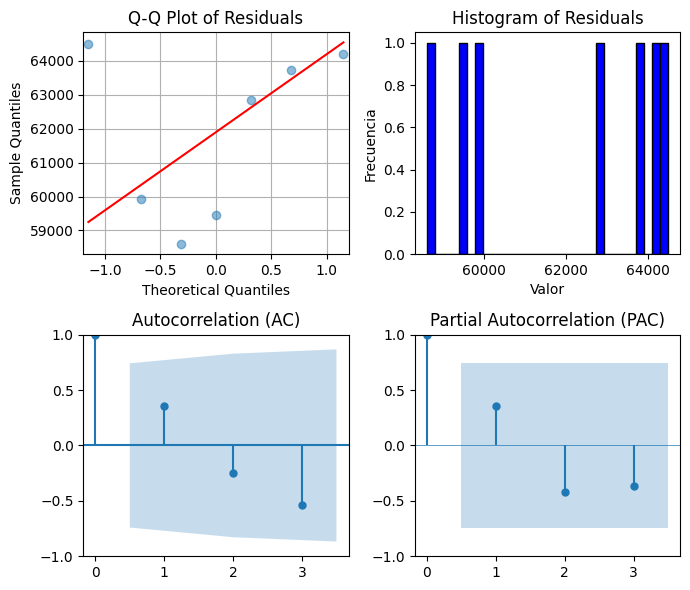

In [135]:
residuos = pd.DataFrame(list(set(yhat_7d) - set(test_7d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos del modelo ARIMA(4,1,4) con rolling en una ventana de 7 días revela que el gráfico cuantil-cuantil y el histograma no proporcionan evidencia clara de que la distribución de los residuos sea normal. Sin embargo, el gráfico de autocorrelación y el gráfico de autocorrelación parcial sugieren que los residuos son estacionarios y no presentan correlaciones significativas. Estos hallazgos indican que, aunque la normalidad de los residuos no está claramente establecida, el modelo parece cumplir con los supuestos de estacionariedad y ausencia de autocorrelación en los residuos. Se realizarán pruebas analíticas adicionales para confirmar estos resultados.

In [140]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.859, p=0.149
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [139]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -1.715572
p-value: 0.423108
Los residuos no son estacionarios (no se rechaza H0)


In [138]:
ljung_box = acorr_ljungbox(residuos, lags=[6], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][6])
print('p-value: %f' % ljung_box['lb_pvalue'][6])

p_value = ljung_box['lb_pvalue'][6]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 9.440277
p-value: 0.150289
Los residuos no están correlacionados (no se rechaza H0)


Los resultados de las pruebas analíticas para el modelo ARIMA(4,1,4) con rolling en una ventana de 7 días indican lo siguiente: la prueba de Shapiro-Wilk confirma que los residuos se aproximan a una distribución normal. Sin embargo, la prueba de Dickey-Fuller revela que los residuos no son estacionarios, lo que podría indicar la presencia de una tendencia o estructura no capturada por el modelo. Finalmente, la prueba de Ljung-Box sugiere que los residuos no están correlacionados, lo que es consistente con la ausencia de autocorrelación en los residuos. Estos resultados destacan la necesidad de considerar ajustes adicionales para abordar la falta de estacionariedad en el modelo.

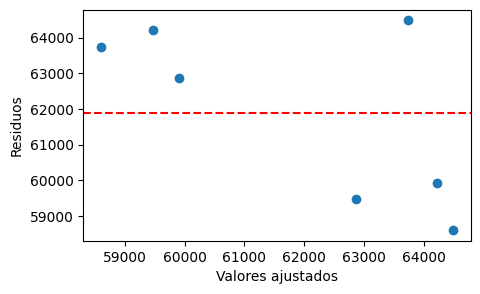

In [137]:
plt.scatter(yhat_7d, residuos)
plt.axhline(y=61897.743094, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

La gráfica de residuos frente a valores ajustados no revela patrones que sugieran heterocedasticidad. Esto indica que la variabilidad de los residuos es consistente a lo largo de los valores ajustados, lo cual es un buen indicio de que el modelo no presenta problemas significativos de variación no constante en los errores.

### Sin Rolling

In [141]:
pronostico = model_fit.forecast(steps=len(dates_7d))

In [142]:
forecast_accuracy(np.array(test_7d), np.array(pronostico), "7 días")

,MAE,MSE,MAPE,RMSE,R2
7 días,2993.551677,1.315560e+07,0.046774,3627.065265,-1.507576


Las métricas de ajuste para el modelo ARIMA (4,1,4) sin rolling en una ventana de 7 días indican un desempeño notablemente inferior en comparación con el modelo con rolling. El MAE, MSE y RMSE son significativamente más altos, lo que sugiere una mayor magnitud de error en las predicciones. El MAPE también es más elevado, indicando una menor precisión en términos relativos. Además, el valor del R² es negativo, lo que indica que el modelo sin rolling no solo tiene un mal ajuste, sino que también es menos adecuado que un modelo que simplemente predice la media de los datos. Esto resalta la importancia de utilizar un enfoque más flexible, como el rolling, para capturar adecuadamente las dinámicas en series temporales con ventanas cortas.

In [143]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': pronostico
})
df_cor.corr(method='spearman')

,Obs,pred
Obs,1.000000,-0.857143
pred,-0.857143,1.000000


In [144]:
df_cor = pd.DataFrame({
    'Obs': test_7d,
    'pred': pronostico
})
df_cor.corr(method='pearson')

,Obs,pred
Obs,1.000000,-0.697054
pred,-0.697054,1.000000


Las correlaciones de Spearman y Pearson entre los datos de prueba y los datos predichos por el modelo ARIMA (4,1,4) sin rolling en una ventana de 7 días son -0.85 y -0.70, respectivamente. Estas correlaciones negativas indican una relación inversa entre los valores observados y las predicciones del modelo, sugiriendo que el modelo tiene dificultades para capturar la estructura de los datos. La magnitud considerable de estas correlaciones negativas refuerza la observación de que el modelo sin rolling tiene un rendimiento deficiente en esta configuración temporal.

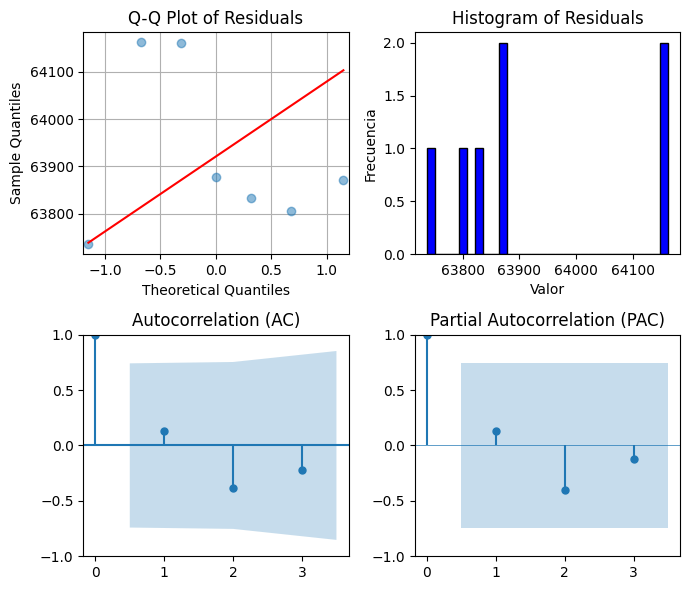

In [145]:
residuos = pd.DataFrame(list(set(pronostico) - set(test_7d)))

# Crear una figura con 2 filas y 2 columnas
fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=False)

# Primer gráfico: Q-Q plot
sm.qqplot(residuos, line='s', ax=axes[0, 0], alpha=0.5, lw=2)
axes[0, 0].set_title('Q-Q Plot of Residuals')
axes[0, 0].set_xlabel('Theoretical Quantiles')
axes[0, 0].set_ylabel('Sample Quantiles')
axes[0, 0].grid(True)

# Segundo gráfico: Histograma
axes[0, 1].hist(residuos, bins=30, color='blue', edgecolor='black')
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Valor')
axes[0, 1].set_ylabel('Frecuencia')

# Tercer gráfico: ACF (en la fila inferior, columna 0)
plot_acf(residuos[0], ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation (AC)')

# Cuarto gráfico: PACF (en la fila inferior, columna 1)
plot_pacf(residuos[0], ax=axes[1, 1], linewidth=0.5)
axes[1, 1].set_title('Partial Autocorrelation (PAC)')

plt.tight_layout()
plt.show()

La inspección visual de los residuos del modelo ARIMA (4,1,4) sin rolling para una ventana de 7 días muestra que tanto el gráfico cuantil-cuantil como el histograma no evidencian una distribución normal de los residuos. No obstante, los gráficos de autocorrelación y autocorrelación parcial sugieren que los residuos son estacionarios y no presentan correlaciones fuertes entre sí. Estos hallazgos destacan que, aunque los residuos cumplen con algunos supuestos importantes, como la estacionariedad y la falta de correlación significativa, la distribución normal de los residuos no está claramente soportada visualmente. Se realizarán pruebas analíticas adicionales para confirmar estas observaciones.

In [146]:
stat, p = shapiro(residuos)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('La muestra se aproxima a una distribución gaussiana (no se rechaza H0)')
else:
    print('La muestra no se aproxima a una distribución gaussiana (se rechaza H0)')

Statistics=0.820, p=0.064
La muestra se aproxima a una distribución gaussiana (no se rechaza H0)


In [147]:
adf_result = adfuller(residuos[0])
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
if 0.05 < adf_result[1]:
    print('Los residuos no son estacionarios (no se rechaza H0)')
else:
    print('Los residuos son estacionarios (se rechaza H0)')

ADF Statistic: -3.009985
p-value: 0.033972
Los residuos son estacionarios (se rechaza H0)


In [149]:
ljung_box = acorr_ljungbox(residuos, lags=[6], return_df=True)

print('LB Statistic: %f' % ljung_box['lb_stat'][6])
print('p-value: %f' % ljung_box['lb_pvalue'][6])

p_value = ljung_box['lb_pvalue'][6]
if p_value < 0.05:
    print('Los residuos están correlacionados (se rechaza H0)')
else:
    print('Los residuos no están correlacionados (no se rechaza H0)')

LB Statistic: 3.398680
p-value: 0.757397
Los residuos no están correlacionados (no se rechaza H0)


Los resultados de las pruebas analíticas para el modelo ARIMA (4,1,4) sin rolling en una ventana de 7 días sugieren un buen ajuste del modelo. La prueba de Shapiro-Wilk respalda la normalidad de los residuos, lo que indica que los errores de predicción se distribuyen adecuadamente. La prueba de Dickey-Fuller confirma que los residuos son estacionarios, lo que es esencial para la validez del modelo. Por último, la prueba de Ljung-Box revela que no hay correlación entre los residuos, sugiriendo que el modelo ha capturado la estructura temporal de los datos de manera efectiva. En conjunto, estas evidencias apoyan la robustez del modelo en términos de sus supuestos fundamentales.

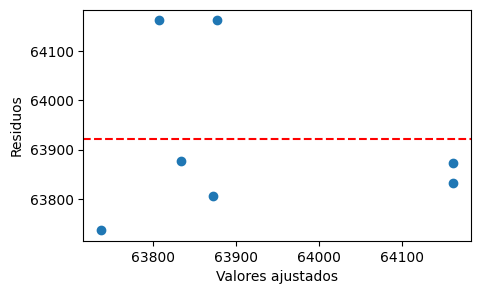

In [152]:
plt.scatter(pronostico, residuos)
plt.axhline(y=63921.111508, color='r', linestyle='--')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

El gráfico de valores ajustados frente a los errores no revela tendencias que sugieran heterocedasticidad, lo que implica que la variabilidad de los residuos no parece depender de los valores ajustados. Sin embargo, dado que el modelo presenta un 
R² negativo, lo cual indica un ajuste deficiente, esta observación sobre la falta de heterocedasticidad no debe ser interpretada como una indicación de un buen rendimiento general del modelo. Aunque el modelo parece no tener problemas evidentes de heterocedasticidad, la calidad de su ajuste sigue siendo insatisfactoria.

### Resultado general: Horizonte de 7 días

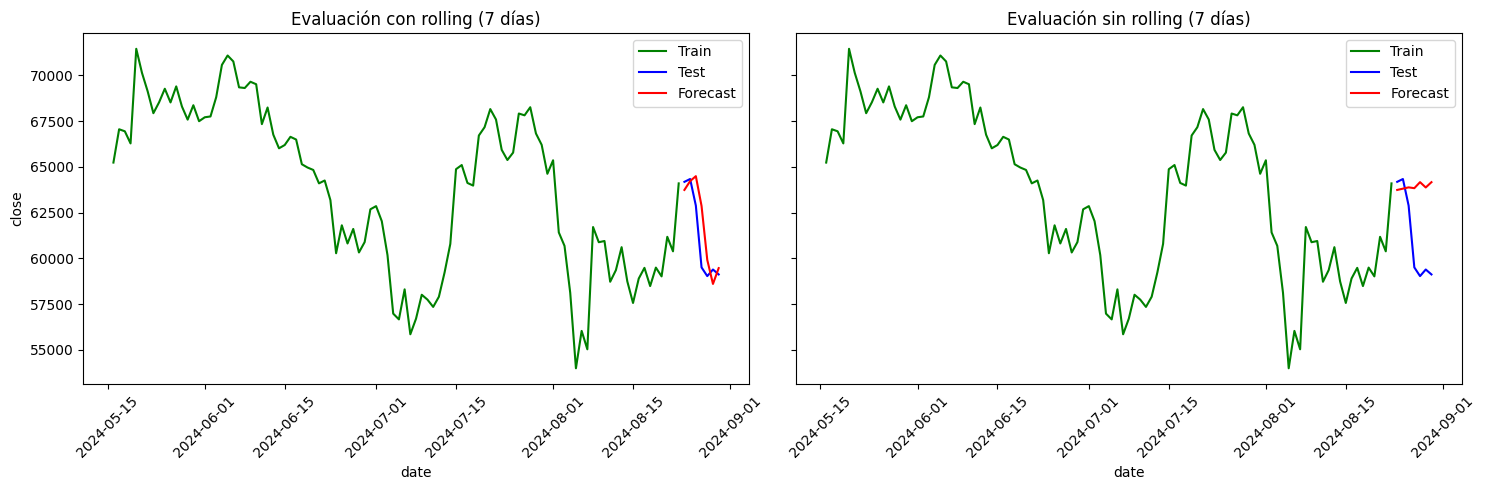

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=True)

# Primera gráfica en la primera columna (0)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[0], label="Train", color='g')
sns.lineplot(x=dates_7d, y=test_7d, ax=axes[0], label="Test", color='b')
sns.lineplot(x=dates_7d, y=yhat_7d, ax=axes[0], label="Forecast", color='r')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Evaluación con rolling (7 días)')

# Segunda gráfica en la segunda columna (1)
sns.lineplot(x=dates_train[-100:], y=train[-100:], ax=axes[1], label="Train", color='g')
sns.lineplot(x=dates_7d, y=test_7d, ax=axes[1], label="Test", color='b')
sns.lineplot(x=dates_7d, y=pronostico, ax=axes[1], label="Forecast", color='r')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Evaluación sin rolling (7 días)')

plt.tight_layout()
plt.show()

En la ventana de 7 días, el modelo ARIMA(4,1,4) muestra un rendimiento notablemente mejor cuando se utiliza la técnica de rolling. Las métricas de ajuste para el modelo con rolling indican una capacidad predictiva adecuada, con errores que se distribuyen normalmente y una capacidad de ajuste relativamente buena. Aunque el  R² es positivo, lo que sugiere una capacidad predictiva moderada, los resultados reflejan la importancia de la técnica de rolling en la evaluación del modelo. Por otro lado, el modelo sin rolling presenta un ajuste deficiente, con métricas de error significativamente más altas y un  R² negativo. En resumen, el uso de rolling mejora la evaluación del modelo, destacando la flexibilidad y efectividad de esta técnica en comparación con la evaluación sin rolling.

## Conclusión del modelo ARIMA(4,1,4)

El modelo ARIMA(4,1,4) muestra un rendimiento notablemente mejor en todas las ventanas de predicción cuando se utiliza la técnica de rolling. En particular, en la ventana de 28 días, el ajuste del modelo con rolling fue el mejor, evidenciado por los errores significativamente más bajos y un índice de ajuste más alto. En comparación, el modelo sin rolling presentó un ajuste deficiente en todas las ventanas, con errores más altos y una capacidad reducida para capturar la variabilidad de los datos. Aunque el rolling proporciona una evaluación más detallada de la capacidad predictiva del modelo, los resultados sugieren que esta técnica tiende a resultar en una mejor evaluación de los datos temporales en comparación con la evaluación sin rolling.

# Conclusión general

El modelo ARIMA(4,1,4) demuestra un rendimiento superior en comparación con el ARIMA(1,2,1) cuando se utiliza la técnica de rolling, especialmente en las ventanas de 28 y 21 días, con errores significativamente más bajos y un mejor índice de ajuste. Aunque el ARIMA(4,1,4) con rolling cumple en gran medida con los supuestos de normalidad, estacionariedad y ausencia de autocorrelación en los residuos, las violaciones al supuesto de estacionariedad en las ventanas de 14 y 7 días sugieren que el modelo ARIMA no logra capturar completamente la estructura temporal de los datos.

Estas violaciones indican la necesidad de considerar otros modelos que puedan abordar mejor la complejidad de la serie temporal. Además, la limitada capacidad de los modelos lineales para capturar la estructura temporal se refleja en las métricas de ajuste difíciles al evaluar los modelos sin rolling, subrayando la importancia de explorar enfoques alternativos para mejorar la precisión y la capacidad predictiva en este contexto.